# Pengembangan *physics informed neural networks* (PINNs) untuk penyelesaian PDP

# 1. Import *Library* dan *Package* yang diperlukan.

Kode dapat dijalankan dengan TensorFlow versi `2.5.x`.
Implementasi model dilakukan dengan *library* [NumPy](https://numpy.org/doc/stable/user/whatisnumpy.html) dan *library* untuk *machine learning* [TensorFlow](https://www.tensorflow.org/).

Telah dikembangkan implementasi *class* untuk pembuatan PINN sebagai objek dari Keras pada sebuah *package* yang disimpan dalam *file* `PINNPDESolver.py`.

Komputasi dilakukan pada Google Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Current Working Directory
dir = '/content/drive/My Drive/Tugas Akhir/Colab'

import sys
sys.path.insert(0, dir)

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Physics-Informed Neural Network
import PINNPDESolver as pinn

# Import Combined Learning Rate Decay
from CombinedDecay import CombinedDecay

# Import time
from time import time

# Import matplotlib for plots
import matplotlib.pyplot as plt

# Creating tables
import pandas as pd
from tabulate import tabulate

Mounted at /content/drive


In [2]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 24,               # LaTeX default is 10pt font.
    "font.size": 24,
    "legend.fontsize": 24,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
plt.rcParams.update(pgf_with_latex)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apach

In [3]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)

# 2. Persamaan Panas dan Transformasi menjadi *Loss Function*

Persamaan panas yang akan digunakan adalah

$$
\begin{equation}
    u_t - c^2u_{xx} = 0, \quad 0<x<l, \quad t>0,
\end{equation}
$$
dengan
$$
c = 1, \quad l=6.
$$
Diberikan *initial condition* (IC)
$$
\begin{equation}
    u(x,\,0) = x(l-x),
\end{equation}
$$
dan *boundary condition* (BC)
$$
\begin{equation}
    u(0,\,t) = u(l,\,t) = 0.
\end{equation}
$$

Solusi unik masalah ini adalah
$$
\begin{equation}
		    u(x,\;t) = \sum_{n=1}^{\infty}\frac{4l^2}{n^3\pi^3} \exp{\left( -\frac{n^2\pi^2c^2t}{l^2} \right)} \sin\left(\frac{n\pi x}{l}\right) (1-(-1)^n).
		\end{equation}
$$

In [4]:
l = 6
const_c = 1

lambda_star = - const_c ** 2

# Define initial condition
def fun_u_0(x):
    return x * (l - x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx, lambd = lambda_star):
    return u_t + lambd * u_xx

In [5]:
# Solusi Eksplisit

lambd_star = const_c ** 2

def u_expl(t_i, x_i):
    """Solusi eksplisit persamaan panas."""
    sum = 0
    for n in range(1,10+1):
      sum += (4*l**2/(n**3*np.pi**3)) * np.sin((n*np.pi*x_i)/l) * np.exp((-n**2*np.pi**2*const_c**2*t_i)/l**2) * (1-(-1)**n)
    return sum

In [6]:
# Set boundary
tmin = 0.
tmax = 10.
xmin = 0.
xmax = l

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Masalah Maju

## 1. Persiapan Pemodelan

### Pembangkitan Data *Training* dan *Collocation Points*

Penentuan Jumlah Data

In [ ]:
# Set number of data points
N_0 = 50
N_b = 50
N_r = 10000

Pembangkitan Data

In [ ]:
plot = True

# Set random seed for reproducible results
tf.random.set_seed(0)

if plot == True:
  # Draw uniform sample points for initial boundary data -> titik di batas domain, definisi domain adalah bidang (x,t)
  t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
  x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
  X_0 = tf.concat([t_0, x_0], axis=1)

  # Evaluate initial condition at x_0
  u_0 = fun_u_0(x_0)

  # Boundary data
  t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
  x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
  X_b = tf.concat([t_b, x_b], axis=1)

  # Evaluate boundary condition at (t_b,x_b)
  u_b = fun_u_b(t_b, x_b)    

  # Collect boundary and inital data in lists
  X_data = [X_0, X_b]
  u_data = [u_0, u_b]

  # Draw uniformly sampled collocation points -> titik interior domain
  t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
  x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
  X_r = tf.concat([t_r, x_r], axis=1)

elif plot == False:
  X_data, u_data, fig = pinn.generate_training_data(N_0, N_b, fun_u_0, fun_u_b, lb, ub)
  X_r = pinn.generate_collocation_points(N_r, lb, ub)

Next, we illustrate the collocation points (red circles) and the positions where the boundary and initial conditions will be enforced (cross marks, color indicates value).

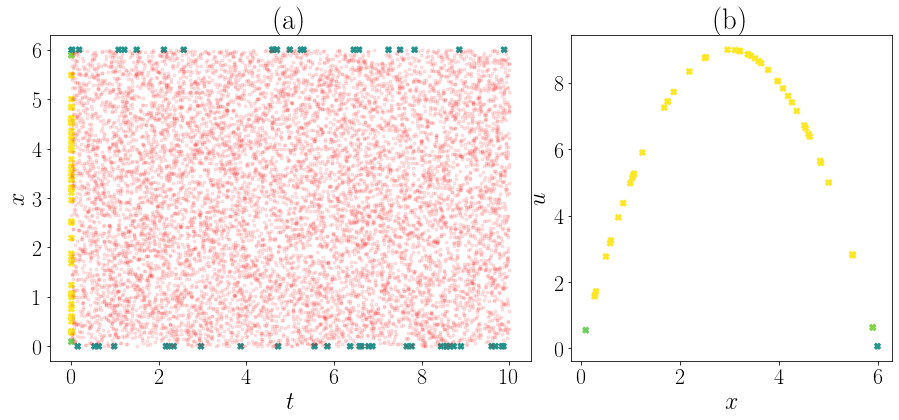

In [ ]:
if plot == True:
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15.1, 6),
                                 gridspec_kw={
                                     'width_ratios': [9, 6],
                                     'wspace': 0.1})
  
  ax1.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
  ax1.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
  ax1.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
  ax1.set_xlabel('$t$')
  ax1.set_ylabel('$x$')
  ax1.set_title('(a)')

  ax2.scatter(x_0, u_0, c=u_0, marker='X', vmin=-1, vmax=1)
  ax2.set_xlabel('$x$')
  ax2.set_ylabel('$u$')
  ax2.set_title('(b)')

  # plt.savefig('heat_eqn_fwd_train.pdf', dpi=600, bbox_inches='tight', facecolor='none')
  plt.show()

### Persiapan Arsitektur PINN

In this example, adopted from 
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)), we assume a feedforward neural network of the following structure:
- the input is scaled elementwise to lie in the interval $[-1,1]$,
- followed by 8 fully connected layers each containing 20 neurons and each followed by a hyperbolic tangent activation function,
- one fully connected output layer.

Pada *hidden layer* pertama, terdapat $2 \times 20 = 40$ parameter bobot dan $20$ parameter bias. Pada 9 *hidden layer* selanjutnya, terdapat $20 \times 20 = 400$ parameter bobot dan $20$ parameter bias dalam setiap *layer*. Di *output layer* yang terhubung *hidden layer* terakhir, terdapat $1 \times 20 = 20$ parameter bobot dan $20$ parameter bias. 

Maka, terdapat sejumlah
    \begin{align*}
        1 \times (40+20) + 9 \times (400+20) + 1 \times (20+20) = 3880
    \end{align*}
parameter yang dapat ditentukan dan diperbarui pada setiap *epoch* dalam PINN.

Akan dibuat sebuah model yang mana bobot-bobot inisialnya akan dimuat pada setiap model yang akan dikembangkan dengan *optimizer* L-BFGS, SGD, dan Adam. Hal ini dilakukan agar analisis hasil kinerja dapat dilakukan dengan adil dikarenakan proses *learning* yang dilakukan dengan kondisi yang sama untuk setiap kasus (inisialisai model *apple to apple*).

In [ ]:
# Setting parameters for model's architecture
arch = {'output_dim':1, 'num_hidden_layers':10, 'num_neurons_per_layer':20, 'activation':'tanh'}

In [ ]:
tf.random.set_seed(1)

# Initializing model weights which will be copied to other models
model = pinn.PINN_NeuralNet(lb, ub, **arch)
model.build(input_shape=(None,2))

In [ ]:
model_LBFGS = pinn.PINN_NeuralNet(lb, ub, **arch)
model_LBFGS.build(input_shape=(None,2))

model_SGD_exp = pinn.PINN_NeuralNet(lb, ub, **arch)
model_SGD_exp.build(input_shape=(None,2))

model_SGD_pw = pinn.PINN_NeuralNet(lb, ub, **arch)
model_SGD_pw.build(input_shape=(None,2))

model_SGD_comb = pinn.PINN_NeuralNet(lb, ub, **arch)
model_SGD_comb.build(input_shape=(None,2))

model_Adam_exp = pinn.PINN_NeuralNet(lb, ub, **arch)
model_Adam_exp.build(input_shape=(None,2))

model_Adam_pw = pinn.PINN_NeuralNet(lb, ub, **arch)
model_Adam_pw.build(input_shape=(None,2))

model_Adam_comb = pinn.PINN_NeuralNet(lb, ub, **arch)
model_Adam_comb.build(input_shape=(None,2))

In [ ]:
# Copying weights
model_LBFGS.set_weights(model.get_weights())
model_SGD_exp.set_weights(model.get_weights())
model_SGD_pw.set_weights(model.get_weights())
model_SGD_comb.set_weights(model.get_weights())
model_Adam_exp.set_weights(model.get_weights())
model_Adam_pw.set_weights(model.get_weights())
model_Adam_comb.set_weights(model.get_weights())

### Persiapan Perhitungan *Loss Function*

In the following code cell, we define a function which evaluates the residual

$$
\begin{align}
    r_\theta (t,x) := \partial_t u_\theta (t,x) + \mathcal{N}[u_\theta] (t,x).
\end{align}
$$

of the nonlinear PDE in the points $X_r = \{(t^r_i,x^r_i)\}_{i=1}^{N_r}$.
To compute the necessary partial derivatives we use the automatic differentiation capabilities of TensorFlow.

For the Heat equation, this entails computing $\partial_t u_\theta$, $\partial_x u_\theta$ and $\partial_{xx} u_\theta$.
In TensorFlow, this is done via a `GradientTape`, see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/GradientTape), which keeps track of the `watched` variables, in our case `t` and `x`, in order to compute the derivatives.

In [ ]:
def get_r(t, x, model, fun_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
      
        tape.watch(x)
        with tf.GradientTape(persistent=True) as tape2:
          # Variables t and x are watched during tape
          # to compute derivatives u_t and u_x
          tape2.watch(t)
          tape2.watch(x)

          # Determine residual 
          u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_t = tape2.gradient(u, t)
        u_x = tape2.gradient(u, x)
            
    
    u_xx = tape.gradient(u_x, x)

    del tape
    del tape2

    return fun_r(t, x, u, u_t, u_x, u_xx)

## 2. Persiapan *Optimizer*

In [ ]:
# Preparing learning rates
lr_exp = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=150,
    decay_rate=0.9)

lr_pw = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000,4000,6000,7000,8000],
                                                             [1e-2,1e-3,5e-4,2.5e-4,1.25e-4,6.25e-5,1.25e-5])

lr_comb = CombinedDecay(boundaries=[3000,4000,6000,7000,8000],
                        initial_learning_rate=1e-2,
                        decay_steps=150,
                        decay_rate=0.9,
                        values_steps=[2,2,2,2,5])

# Preparing the optimizer
optim_SGD_exp = tf.keras.optimizers.SGD(learning_rate=lr_exp)
optim_Adam_exp = tf.keras.optimizers.Adam(learning_rate=lr_exp)

optim_SGD_pw = tf.keras.optimizers.SGD(learning_rate=lr_pw)
optim_Adam_pw = tf.keras.optimizers.Adam(learning_rate=lr_pw)

optim_SGD_comb = tf.keras.optimizers.SGD(learning_rate=lr_comb)
optim_Adam_comb = tf.keras.optimizers.Adam(learning_rate=lr_comb)

In [ ]:
lr_comb.get_config()

{'initial_learning_rate': 0.01,
 'decay_steps': 150,
 'decay_rate': 0.9,
 'staircase': False,
 'boundaries': [3000, 4000, 6000, 7000, 8000],
 'values': [0.0012157665459056935,
  0.0006078832729528468,
  0.0003039416364764234,
  0.0001519708182382117,
  7.598540911910585e-05,
  1.519708182382117e-05],
 'values_steps': [2, 2, 2, 2, 5],
 'name': None}

### Penggunaan Learning Rate

Berikut adalah beberapa grafik yang menggambarkan evolusi *learning rate* seiring berjalannya iterasi atau *epoch*. 


*   Pada penggunaan `ExponentialDecay`, *learning rate* diperkecil agar proses *learning* dengan algoritma *gradient descent* dapat dilakukan dengan *loss* yang stabil.
*   Pada penggunaan `PiecewiseConstantDecay`, *learning rate* diperkecil mengikuti sebuah *piecewise function*. Dampak dari penggunaan metode ini adalah *loss* yang masih dapat berkurang ketika telah berada di iterasi *learning* yang secara relatif besar. 
*   Pada penggunaan *hybrid learning rate* yang digunakan, dipertahankan stabilitas yang terdapat pada penggunaan `ExponentialDecay` di awal iterasi serta proses *learning* dapat dilakukan dengan baik pada iterasi-iterasi akhir yang terdapat ketika digunakan `PiecewiseConstantDecay`.



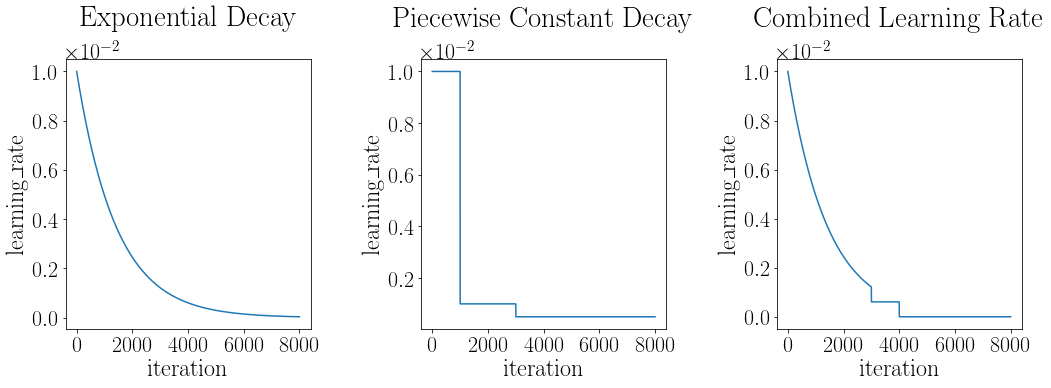

In [ ]:
N = 8000

fig = plt.figure(figsize=(15.1,6))

# ExponentialDecay:
initial_learning_rate=1e-2
decay_steps=150
decay_rate=0.9

learning_rate = []
for i in range(N+1):
  learning_rate.append(initial_learning_rate * decay_rate ** (i / decay_steps))

plt.subplot(1, 3, 1)
plt.plot(learning_rate)
plt.xlabel('iteration')
plt.ylabel('learning\_rate')
plt.xticks(np.arange(0, N+1, 2000))
plt.ticklabel_format(axis='y', scilimits=(0,0))
plt.title('Exponential Decay', y=1.1)


# PiecewiseConstantDecay:
boundaries = [1000,3000,4000,6000]
values = [1e-2,1e-3,5e-4,2.5e-4, 1.25e-4]

learning_rate = []
for i in range(N+1):
  if (i > boundaries[1]):
    learning_rate.append(values[2])
  elif (i > boundaries[0]):
    learning_rate.append(values[1])
  else:
    learning_rate.append(values[0])

plt.subplot(1, 3, 2)
plt.plot(learning_rate)
plt.xlabel('iteration')
plt.ylabel('learning\_rate')
plt.xticks(np.arange(0, N+1, 2000))
plt.ticklabel_format(axis='y', scilimits=(0,0))
plt.title('Piecewise Constant Decay', y=1.1)


# Combined Learning Rate:
# i_stop = 3000
# boundaries = [3000,4000,6000]

# learning_rate = []
# for i in range(N+1):
#   if (i <= i_stop):
#     learning_rate.append(initial_learning_rate * decay_rate ** (i / decay_steps))
#   elif (i_stop < i <= boundaries[0]):    
#     learning_rate.append(initial_learning_rate * decay_rate ** (i_stop / decay_steps))
#   elif (boundaries[0] < i <= boundaries[1]):
#     learning_rate.append((initial_learning_rate * decay_rate ** (i_stop / decay_steps))/2)
#   else:
#     learning_rate.append((initial_learning_rate * decay_rate ** (i_stop / decay_steps))/4)

boundaries = [3000,4000,6000]
values_steps=[2,2,2]
i_stop = boundaries[0]

learning_rate = []
for i in range(N+1):
  if (i <= i_stop):
    learning_rate.append(initial_learning_rate * decay_rate ** (i / decay_steps))
  elif (i_stop < i <= boundaries[1]):    
    learning_rate.append(initial_learning_rate * decay_rate ** (i_stop / decay_steps)/values_steps[0])
  elif (boundaries[1] < i <= boundaries[2]):
    learning_rate.append(learning_rate[-1]/values_steps[1])
  elif (i > boundaries[2]):
    learning_rate.append(learning_rate[-1]/values_steps[2])

plt.subplot(1, 3, 3)
plt.plot(learning_rate)
plt.xlabel('iteration')
plt.ylabel('learning\_rate')
plt.xticks(np.arange(0, N+1, 2000))
plt.ticklabel_format(axis='y', scilimits=(0,0))
plt.title('Combined Learning Rate', y=1.1)

# plt.suptitle("Learning Rate")

plt.tight_layout()
# plt.savefig('learning_rate.pdf', dpi=600, bbox_inches='tight', facecolor='none')
plt.show()

## 3. *Training* Model dan Prediksi Solusi

In [ ]:
# Setting learning timeout
timeout = 100

# Initilize PINN solver
solver_LBFGS = pinn.PINN_PDESolver(model_LBFGS, X_r, fun_r, get_r)

solver_SGD_exp = pinn.PINN_PDESolver(model_SGD_exp, X_r, fun_r, get_r)
solver_SGD_pw = pinn.PINN_PDESolver(model_SGD_pw, X_r, fun_r, get_r)
solver_SGD_comb = pinn.PINN_PDESolver(model_SGD_comb, X_r, fun_r, get_r)

solver_Adam_exp = pinn.PINN_PDESolver(model_Adam_exp, X_r, fun_r, get_r)
solver_Adam_pw = pinn.PINN_PDESolver(model_Adam_pw, X_r, fun_r, get_r)
solver_Adam_comb = pinn.PINN_PDESolver(model_Adam_comb, X_r, fun_r, get_r)

###LBFGS

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_LBFGS.solve_with_ScipyOptimizer(X_data, u_data, timeout=timeout, method='L-BFGS-B')

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: l_u = 6.79009184e-02 l_f = 2.27073695e+01 loss = 2.27752705e+01
It 00050: l_u = 3.82288136e-02 l_f = 2.95335613e-02 loss = 6.77623749e-02
It 00100: l_u = 1.21197132e-02 l_f = 3.75203136e-03 loss = 1.58717446e-02


KeyboardInterrupt: ignored

### SGD

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_SGD_exp.solve_with_TFoptimizer(optim_SGD_exp, X_data, u_data, timeout=timeout)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Initial Learning Rate = 1.00000e-02
It 00000: l_u = 4.60430700e-03 l_f = 3.98740845e+01 loss = 3.98786888e+01
It 00050: l_u = 1.10952759e+00 l_f = 7.48466301e+00 loss = 8.59419060e+00
It 00100: l_u = 2.24328947e+00 l_f = 5.03400946e+00 loss = 7.27729893e+00
It 00150: l_u = 9.18767393e-01 l_f = 2.06283003e+00 loss = 2.98159742e+00
It 00200: l_u = 8.23215723e-01 l_f = 1.78221512e+00 loss = 2.60543084e+00
It 00250: l_u = 5.50648451e-01 l_f = 1.06862438e+00 loss = 1.61927283e+00
It 00300: l_u = 3.79375279e-01 l_f = 7.80116141e-01 loss = 1.15949142e+00
It 00350: l_u = 4.71332461e-01 l_f = 1.46261427e+00 loss = 1.93394673e+00


KeyboardInterrupt: ignored

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_SGD_pw.solve_with_TFoptimizer(optim_SGD_pw, X_data, u_data, timeout=timeout)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_SGD_comb.solve_with_TFoptimizer(optim_SGD_comb, X_data, u_data, timeout=timeout)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

###Adam

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_Adam_exp.solve_with_TFoptimizer(optim_Adam_exp, X_data, u_data, timeout=timeout)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Initial Learning Rate = 1.00000e-02
It 00000: loss = 3.98735466e+01
It 00050: loss = 2.50512958e-01
It 00100: loss = 4.65642735e-02
It 00150: loss = 1.83358919e-02
It 00200: loss = 1.21948775e-02
It 00250: loss = 2.00810134e-02
It 00300: loss = 8.68061744e-03
It 00350: loss = 6.27739634e-03
It 00400: loss = 4.98952344e-03
It 00450: loss = 7.11235553e-02
It 00500: loss = 5.17313275e-03
It 00550: loss = 3.88620561e-03
It 00600: loss = 3.47805489e-03
It 00650: loss = 3.22955870e-03
It 00700: loss = 3.05722351e-03
It 00750: loss = 2.92805280e-03
It 00800: loss = 2.82597472e-03
It 00850: loss = 6.05046339e-02
It 00900: loss = 3.96428723e-03
It 00950: loss = 2.77802465e-03
It 01000: loss = 2.68705003e-03
It 01050: loss = 2.61621550e-03
It 01100: loss = 2.55673262e-03
It 01150: loss = 2.50498205e-03
It 01200: loss = 2.45888275e-03
It 01250: loss = 2.41712248e-03
It 01300: loss = 2.37883418e-03
It 01350: loss = 2.34341039e-03
It 01400: loss = 2.31038965e-03
It 01450: loss = 2.27941433e-03
It 0

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_Adam_pw.solve_with_TFoptimizer(optim_Adam_pw, X_data, u_data, timeout=timeout)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Initial Learning Rate = 1.00000e-02
It 00000: loss = 3.98735466e+01
It 00050: loss = 3.03917557e-01
It 00100: loss = 9.37678441e-02
It 00150: loss = 2.34805550e-02
It 00200: loss = 1.19481031e-02
It 00250: loss = 1.34954989e-01
It 00300: loss = 9.62677691e-03
It 00350: loss = 5.69412485e-03
It 00400: loss = 3.26456204e-02
It 00450: loss = 4.67064604e-03
It 00500: loss = 3.90393427e-03
It 00550: loss = 6.48775920e-02
It 00600: loss = 9.23432037e-03
It 00650: loss = 4.89749666e-03
It 00700: loss = 1.10892495e-02
It 00750: loss = 4.78961645e-03
It 00800: loss = 9.56470706e-03
It 00850: loss = 3.52399657e-03
It 00900: loss = 8.34807940e-03
It 00950: loss = 1.97147802e-02
It 01000: loss = 3.00644897e-03
It 01050: loss = 2.85061193e-03
It 01100: loss = 2.81134737e-03
It 01150: loss = 2.77445395e-03
It 01200: loss = 2.73932843e-03
It 01250: loss = 2.70580291e-03
It 01300: loss = 2.67370883e-03
It 01350: loss = 2.64290441e-03
It 01400: loss = 2.61328067e-03
It 01450: loss = 2.58477265e-03
It 0

In [ ]:
# Start timer
t0 = time()

tf.random.set_seed(0)
solver_Adam_comb.solve_with_TFoptimizer(optim_Adam_comb, X_data, u_data, timeout=timeout)

# Print computation time

print('\nComputation time: {} seconds'.format(time()-t0))

Initial Learning Rate = 1.00000e-02
It 00000: loss = 3.98735466e+01
It 00050: loss = 2.50520080e-01
It 00100: loss = 4.49505970e-02
It 00150: loss = 1.84140503e-02
It 00200: loss = 1.22034857e-02
It 00250: loss = 3.68155837e-02
It 00300: loss = 8.74513667e-03
It 00350: loss = 6.28980063e-03
It 00400: loss = 4.98770084e-03
It 00450: loss = 4.55343500e-02
It 00500: loss = 1.31277163e-02
It 00550: loss = 4.06657904e-03
It 00600: loss = 3.53953708e-03
It 00650: loss = 3.27178068e-03
It 00700: loss = 3.08939302e-03
It 00750: loss = 2.95401481e-03
It 00800: loss = 2.84775975e-03
It 00850: loss = 2.76098074e-03
It 00900: loss = 2.70688999e-03
It 00950: loss = 1.03696436e-02
It 01000: loss = 2.75373412e-03
It 01050: loss = 2.63808155e-03
It 01100: loss = 2.57254485e-03
It 01150: loss = 2.51754140e-03
It 01200: loss = 2.46939762e-03
It 01250: loss = 2.42624641e-03
It 01300: loss = 2.38694646e-03
It 01350: loss = 2.35075923e-03
It 01400: loss = 2.31714058e-03
It 01450: loss = 2.28569354e-03
It 0

### Grafik *Loss*

In [ ]:
hist_LBFGS = solver_LBFGS.hist
hist_SGD_exp = solver_SGD_exp.hist
hist_SGD_pw = solver_SGD_pw.hist
hist_SGD_comb = solver_SGD_comb.hist
hist_Adam_exp = solver_Adam_exp.hist
hist_Adam_pw = solver_Adam_pw.hist
hist_Adam_comb = solver_Adam_comb.hist

NameError: ignored

In [ ]:
timeout = 100
x_LBFGS = np.linspace(0, timeout, len(hist_LBFGS))
x_SGD_exp = np.linspace(0, timeout, len(hist_SGD_exp))
x_SGD_pw = np.linspace(0, timeout, len(hist_SGD_pw))
x_SGD_comb = np.linspace(0, timeout, len(hist_SGD_comb))
x_Adam_exp = np.linspace(0, timeout, len(hist_Adam_exp))
x_Adam_pw = np.linspace(0, timeout, len(hist_Adam_pw))
x_Adam_comb = np.linspace(0, timeout, len(hist_Adam_comb))

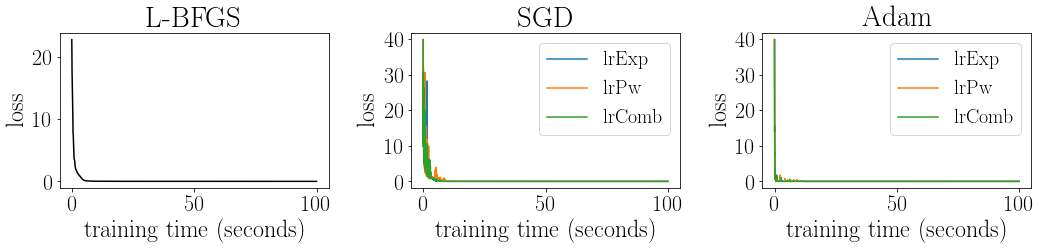

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

ax1.plot(x_LBFGS, hist_LBFGS, c='black')
ax1.set_xlabel('training time (seconds)')
ax1.set_ylabel('loss')
ax1.set_title('L-BFGS')

ax2.plot(x_SGD_exp, hist_SGD_exp)
ax2.plot(x_SGD_pw, hist_SGD_pw)
ax2.plot(x_SGD_comb, hist_SGD_comb)
ax2.legend(['lrExp', 'lrPw', 'lrComb'], fontsize=20)
ax2.set_xlabel('training time (seconds)')
ax2.set_ylabel('loss')
ax2.set_title('SGD')

ax3.plot(x_Adam_exp, hist_Adam_exp)
ax3.plot(x_Adam_pw, hist_Adam_pw)
ax3.plot(x_Adam_comb, hist_Adam_comb)
ax3.legend(['lrExp', 'lrPw', 'lrComb'], fontsize=20)
ax3.set_xlabel('training time (seconds)')
ax3.set_ylabel('loss')
ax3.set_title('Adam')

ax1.set_yticks(np.arange(0, max(hist_LBFGS), 10))
ax2.set_yticks(np.arange(0, 40+1, 10))
ax3.set_yticks(np.arange(0, 40+1, 10))

plt.tight_layout()
# plt.savefig('heat_eqn_fwd_loss.pdf', dpi=600, bbox_inches='tight', facecolor='none')
plt.show()

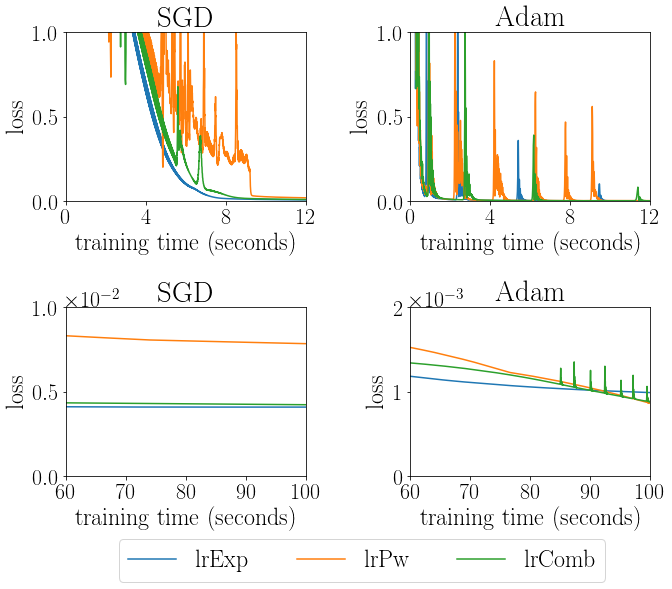

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

axs[0][0].plot(x_SGD_exp, hist_SGD_exp, label='lrExp')
axs[0][0].plot(x_SGD_pw, hist_SGD_pw, label='lrPw')
axs[0][0].plot(x_SGD_comb, hist_SGD_comb, label='lrComb')
axs[0][0].set_xlabel('training time (seconds)')
axs[0][0].set_ylabel('loss')
axs[0][0].set_xlim([0, 12])
axs[0][0].set_ylim([0, 1])
axs[0][0].set_title('SGD')

axs[0][1].plot(x_Adam_exp, hist_Adam_exp, label='lrExp')
axs[0][1].plot(x_Adam_pw, hist_Adam_pw, label='lrPw')
axs[0][1].plot(x_Adam_comb, hist_Adam_comb, label='lrComb')
axs[0][1].set_xlabel('training time (seconds)')
axs[0][1].set_ylabel('loss')
axs[0][1].set_xlim([0, 12])
axs[0][1].set_ylim([0, 1])
axs[0][1].set_title('Adam')

axs[1][0].plot(x_SGD_exp, hist_SGD_exp, label='lrExp')
axs[1][0].plot(x_SGD_pw, hist_SGD_pw, label='lrPw')
axs[1][0].plot(x_SGD_comb, hist_SGD_comb, label='lrComb')
axs[1][0].set_xlabel('training time (seconds)')
axs[1][0].set_ylabel('loss')
axs[1][0].set_xlim([60, 100])
axs[1][0].set_ylim([0, 1e-2])
axs[1][0].set_title('SGD')

axs[1][1].plot(x_Adam_exp, hist_Adam_exp, label='lrExp')
axs[1][1].plot(x_Adam_pw, hist_Adam_pw, label='lrPw')
axs[1][1].plot(x_Adam_comb, hist_Adam_comb, label='lrComb')
axs[1][1].set_xlabel('training time (seconds)')
axs[1][1].set_ylabel('loss')
axs[1][1].set_xlim([60, 100])
axs[1][1].set_ylim([0, 2e-3])
axs[1][1].set_title('Adam')

axs[0][0].set_xticks(np.arange(0, 12+1, 4))
axs[0][1].set_xticks(np.arange(0, 12+1, 4))
axs[1][0].set_xticks(np.arange(60, 100+1, 10))
axs[1][1].set_xticks(np.arange(60, 100+1, 10))
axs[1][0].ticklabel_format(axis='y', scilimits=(0,0))
axs[1][1].ticklabel_format(axis='y', scilimits=(0,0))

plt.tight_layout()
axs[1][1].legend(loc='upper center', bbox_to_anchor=(-0.2, -0.3), ncol=3)

# plt.savefig('heat_eqn_fwd_loss_detailed.pdf', dpi=600, bbox_inches='tight', facecolor='none')
plt.show()

### Solusi Model

In [ ]:
Nt = 1000; Nx = 1000
tspace = np.linspace(lb[0], ub[0], Nt + 1)
xspace = np.linspace(lb[1], ub[1], Nx + 1)
T, X = np.meshgrid(tspace, xspace)

Solusi L-BFGS

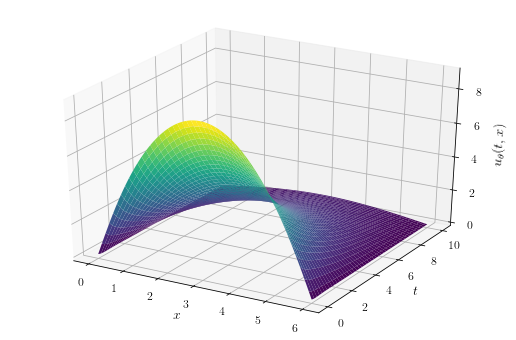

In [ ]:
u_LBFGS = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_LBFGS)

Solusi SGD

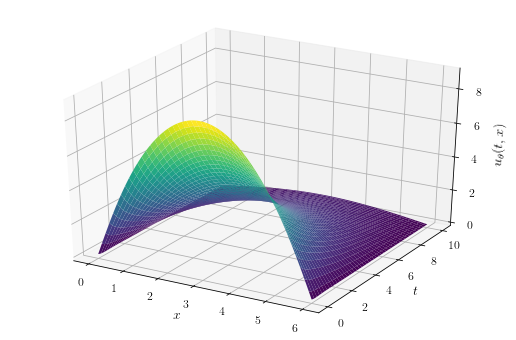

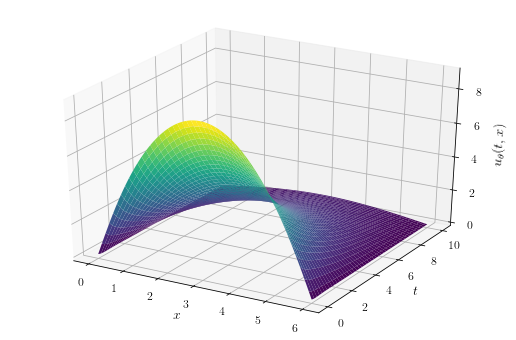

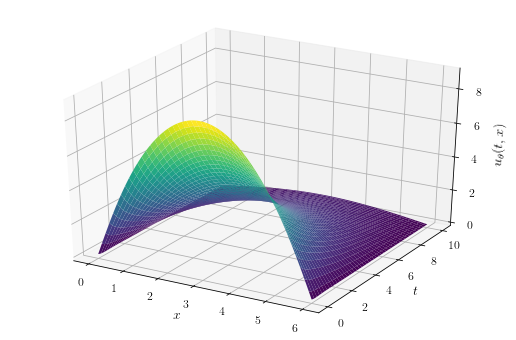

In [ ]:
u_SGD_exp = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_SGD_exp)
u_SGD_pw = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_SGD_pw)
u_SGD_comb = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_SGD_comb)

Solusi Adam

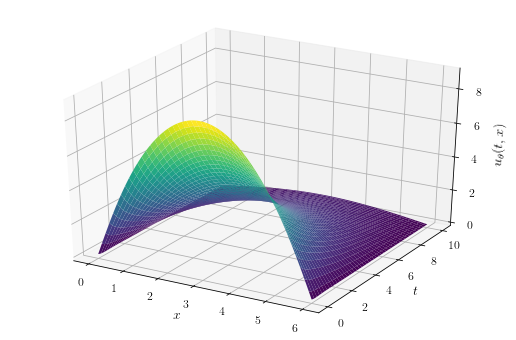

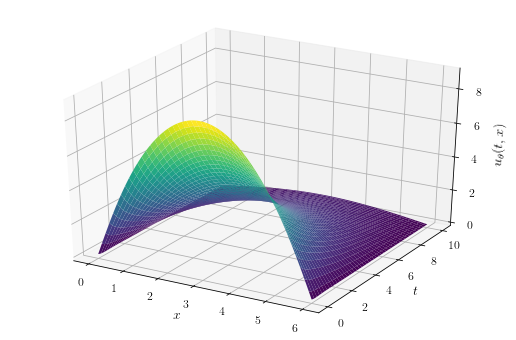

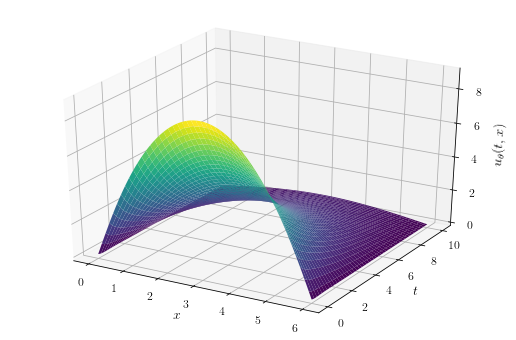

In [ ]:
u_Adam_exp = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_Adam_exp)
u_Adam_pw = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_Adam_pw)
u_Adam_comb = solver_LBFGS.predict_solution(Nt=Nt, Nx=Nx)
solver_LBFGS.plot_solution(u_Adam_comb)

### *Export Trained* Model

In [ ]:
path = dir + "/model weights/heat_eqn_fwd"

model_LBFGS.save_weights(path+"/model_LBFGS.h5", 'h5')
model_SGD_exp.save_weights(path+"/model_SGD_exp.h5", 'h5')
model_SGD_pw.save_weights(path+"/model_SGD_pw.h5", 'h5')
model_SGD_comb.save_weights(path+"/model_SGD_comb.h5", 'h5')
model_Adam_exp.save_weights(path+"/model_Adam_exp.h5", 'h5')
model_Adam_pw.save_weights(path+"/model_Adam_pw.h5", 'h5')
model_Adam_comb.save_weights(path+"/model_Adam_comb.h5", 'h5')

In [ ]:
np.savetxt(path+"/loss/hist_LBFGS.txt", solver_LBFGS.hist)
np.savetxt(path+"/loss/hist_SGD_exp.txt", solver_SGD_exp.hist)
np.savetxt(path+"/loss/hist_SGD_pw.txt", solver_SGD_pw.hist)
np.savetxt(path+"/loss/hist_SGD_comb.txt", solver_SGD_comb.hist)
np.savetxt(path+"/loss/hist_Adam_exp.txt", solver_Adam_exp.hist)
np.savetxt(path+"/loss/hist_Adam_pw.txt", solver_Adam_pw.hist)
np.savetxt(path+"/loss/hist_Adam_comb.txt", solver_Adam_comb.hist)

### *Import Trained* Model

In [ ]:
path = dir + "/model weights/heat_eqn_fwd"
model_LBFGS.load_weights(path+"/model_LBFGS.h5")
model_SGD_exp.load_weights(path+"/model_SGD_exp.h5")
model_SGD_pw.load_weights(path+"/model_SGD_pw.h5")
model_SGD_comb.load_weights(path+"/model_SGD_comb.h5")
model_Adam_exp.load_weights(path+"/model_Adam_exp.h5")
model_Adam_pw.load_weights(path+"/model_Adam_pw.h5")
model_Adam_comb.load_weights(path+"/model_Adam_comb.h5")

hist_LBFGS = np.loadtxt(path+"/loss/hist_LBFGS.txt")
hist_SGD_exp = np.loadtxt(path+"/loss/hist_SGD_exp.txt")
hist_SGD_pw = np.loadtxt(path+"/loss/hist_SGD_pw.txt")
hist_SGD_comb = np.loadtxt(path+"/loss/hist_SGD_comb.txt")
hist_Adam_exp = np.loadtxt(path+"/loss/hist_Adam_exp.txt")
hist_Adam_pw = np.loadtxt(path+"/loss/hist_Adam_pw.txt")
hist_Adam_comb = np.loadtxt(path+"/loss/hist_Adam_comb.txt")

## Pengembangan 5 Buah Model dengan Masing-Masing *Optimizer*

In [ ]:
n_models = 5
arch = {'output_dim':1, 'num_hidden_layers':10, 'num_neurons_per_layer':20, 'activation':'tanh'}

In [ ]:
# Set up model architecture & 
# initialize weights to be copied to other models

models = [None] * n_models

for i in range(n_models):
  tf.random.set_seed(i)
  models[i] = pinn.PINN_NeuralNet(lb=lb, ub=ub, **arch)
  models[i].build((None, 2))

In [ ]:
timeout = 100
start_from = 1

path = dir + "/model weights/heat_eqn_fwd"
models_LBFGS = [None]*(start_from-1)
models_SGD_exp = [None]*(start_from-1)
models_SGD_pw = [None]*(start_from-1)
models_SGD_comb = [None]*(start_from-1)
models_Adam_exp = [None]*(start_from-1)
models_Adam_pw = [None]*(start_from-1)
models_Adam_comb = [None]*(start_from-1)
hists_LBFGS = [None]*(start_from-1)
hists_SGD_exp = [None]*(start_from-1)
hists_SGD_pw = [None]*(start_from-1)
hists_SGD_comb = [None]*(start_from-1)
hists_Adam_exp = [None]*(start_from-1)
hists_Adam_pw = [None]*(start_from-1)
hists_Adam_comb = [None]*(start_from-1)



for i in range(start_from-1, n_models):
  print('{:s}\nIteration: {:d}\n{:s}'.format(50*'-',i+1,50*'-'))

  tf.random.set_seed(i)
  models_LBFGS.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_exp.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_pw.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_comb.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_exp.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_pw.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_comb.append(pinn.PINN_NeuralNet(lb, ub, **arch))

  models_LBFGS[i].build(input_shape=(None,2))
  models_SGD_exp[i].build(input_shape=(None,2))
  models_SGD_pw[i].build(input_shape=(None,2))
  models_SGD_comb[i].build(input_shape=(None,2))
  models_Adam_exp[i].build(input_shape=(None,2))
  models_Adam_pw[i].build(input_shape=(None,2))
  models_Adam_comb[i].build(input_shape=(None,2))

  # Copy weights from the previous model instance to make every iteration comparable  
  models_LBFGS[i].set_weights(models[i].get_weights())
  models_SGD_exp[i].set_weights(models[i].get_weights())
  models_SGD_pw[i].set_weights(models[i].get_weights())
  models_SGD_comb[i].set_weights(models[i].get_weights())
  models_Adam_exp[i].set_weights(models[i].get_weights())
  models_Adam_pw[i].set_weights(models[i].get_weights())
  models_Adam_comb[i].set_weights(models[i].get_weights())

  # Prepare optimizers
  optim_SGD_exp = tf.keras.optimizers.SGD(learning_rate=lr_exp)
  optim_SGD_pw = tf.keras.optimizers.SGD(learning_rate=lr_pw)
  optim_SGD_comb = tf.keras.optimizers.SGD(learning_rate=lr_comb)
  optim_Adam_exp = tf.keras.optimizers.Adam(learning_rate=lr_exp)
  optim_Adam_pw = tf.keras.optimizers.Adam(learning_rate=lr_pw)
  optim_Adam_comb = tf.keras.optimizers.Adam(learning_rate=lr_comb) 

  # Initialize solvers
  solver_LBFGS = pinn.PINN_PDESolver(models_LBFGS[i], X_r, fun_r, get_r)
  solver_SGD_exp = pinn.PINN_PDESolver(models_SGD_exp[i], X_r, fun_r, get_r)
  solver_SGD_pw = pinn.PINN_PDESolver(models_SGD_pw[i], X_r, fun_r, get_r)
  solver_SGD_comb = pinn.PINN_PDESolver(models_SGD_comb[i], X_r, fun_r, get_r)
  solver_Adam_exp = pinn.PINN_PDESolver(models_Adam_exp[i], X_r, fun_r, get_r)
  solver_Adam_pw = pinn.PINN_PDESolver(models_Adam_pw[i], X_r, fun_r, get_r)
  solver_Adam_comb = pinn.PINN_PDESolver(models_Adam_comb[i], X_r, fun_r, get_r)

  # Train models
  print('\n\nL-BFGS\n')
  solver_LBFGS.solve_with_ScipyOptimizer(X_data, u_data,
                                        timeout=timeout,
                                        method='L-BFGS-B')
  print('\n\nSGD - Exponential Decay\n')
  solver_SGD_exp.solve_with_TFoptimizer(optim_SGD_exp, X_data, u_data, timeout=timeout)
  print('\n\nSGD - Piecewise Constant Decay\n')
  solver_SGD_pw.solve_with_TFoptimizer(optim_SGD_pw, X_data, u_data, timeout=timeout)
  print('\n\nSGD - Combined Learning Rate\n')
  solver_SGD_comb.solve_with_TFoptimizer(optim_SGD_comb, X_data, u_data, timeout=timeout)
  print('\n\nAdam - Exponential Decay\n')
  solver_Adam_exp.solve_with_TFoptimizer(optim_Adam_exp, X_data, u_data, timeout=timeout)
  print('\n\nAdam - Piecewise Constant Decay\n')
  solver_Adam_pw.solve_with_TFoptimizer(optim_Adam_pw, X_data, u_data, timeout=timeout)
  print('\n\nAdam - Combined Learning Rate\n')
  solver_Adam_comb.solve_with_TFoptimizer(optim_Adam_comb, X_data, u_data, timeout=timeout)
  
  # Store evolution of lambdas and hists
  hists_LBFGS.append(solver_LBFGS.hist)
  hists_SGD_exp.append(solver_SGD_exp.hist)
  hists_SGD_pw.append(solver_SGD_pw.hist)
  hists_SGD_comb.append(solver_SGD_comb.hist)
  hists_Adam_exp.append(solver_Adam_exp.hist)
  hists_Adam_pw.append(solver_Adam_pw.hist)
  hists_Adam_comb.append(solver_Adam_comb.hist)

  print('\n\n\n')    

  # Export Model Weights and Losses
  models_LBFGS[i].save_weights(path+"_"+str(i)+"/model_LBFGS.h5", 'h5')
  models_SGD_exp[i].save_weights(path+"_"+str(i)+"/model_SGD_exp.h5", 'h5')
  models_SGD_pw[i].save_weights(path+"_"+str(i)+"/model_SGD_pw.h5", 'h5')
  models_SGD_comb[i].save_weights(path+"_"+str(i)+"/model_SGD_comb.h5", 'h5')
  models_Adam_exp[i].save_weights(path+"_"+str(i)+"/model_Adam_exp.h5", 'h5')
  models_Adam_pw[i].save_weights(path+"_"+str(i)+"/model_Adam_pw.h5", 'h5')
  models_Adam_comb[i].save_weights(path+"_"+str(i)+"/model_Adam_comb.h5", 'h5')

  np.savetxt(path+"_"+str(i)+"/loss/hist_LBFGS.txt", hists_LBFGS[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_exp.txt", hists_SGD_exp[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_pw.txt", hists_SGD_pw[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_comb.txt", hists_SGD_comb[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_exp.txt", hists_Adam_exp[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_pw.txt", hists_Adam_pw[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_comb.txt", hists_Adam_comb[i])

--------------------------------------------------
Iteration: 1
--------------------------------------------------


L-BFGS

It 00000: loss = 3.16073513e+01
It 00050: loss = 6.54370904e-01
It 00100: loss = 3.51726599e-02
It 00150: loss = 1.49947312e-02
It 00200: loss = 1.03511317e-02
It 00250: loss = 7.47038191e-03
It 00300: loss = 5.92401391e-03
It 00350: loss = 4.64941235e-03
It 00400: loss = 3.35726258e-03
It 00450: loss = 2.77266442e-03
It 00500: loss = 2.54614139e-03
It 00550: loss = 2.38045212e-03
It 00600: loss = 2.18298519e-03
It 00650: loss = 2.00437126e-03
It 00700: loss = 1.90039654e-03
It 00750: loss = 1.75449415e-03
It 00800: loss = 1.65890506e-03
It 00850: loss = 1.59789575e-03
It 00900: loss = 1.53893873e-03
It 00950: loss = 1.49416691e-03
It 01000: loss = 1.42974767e-03
It 01050: loss = 1.36737688e-03
It 01100: loss = 1.27431075e-03
Timeout is reached. Time elapsed: 100.01924300193787


SGD - Exponential Decay

Initial Learning Rate = 1.00000e-02
It 00000: loss = 4.5574

### *Export* Model
*Export* hasil *training* model agar bisa digunakan di luar *training runtime*. *Export* meliputi parameter model dan riwayat *loss* yang diperoleh.

*Export* bobot dan bias yang diperoleh pada *training*.

In [ ]:
path = dir + "/model weights/heat_eqn_fwd"

for i in range(n_models):  
	models_LBFGS[i].save_weights(path+"_"+str(i)+"/model_LBFGS.h5", 'h5')
	models_SGD_exp[i].save_weights(path+"_"+str(i)+"/model_SGD_exp.h5", 'h5')
	models_SGD_pw[i].save_weights(path+"_"+str(i)+"/model_SGD_pw.h5", 'h5')
	models_SGD_comb[i].save_weights(path+"_"+str(i)+"/model_SGD_comb.h5", 'h5')
	models_Adam_exp[i].save_weights(path+"_"+str(i)+"/model_Adam_exp.h5", 'h5')
	models_Adam_pw[i].save_weights(path+"_"+str(i)+"/model_Adam_pw.h5", 'h5')
	models_Adam_comb[i].save_weights(path+"_"+str(i)+"/model_Adam_comb.h5", 'h5')

*Export* perkembangan *loss* pada *training* dalam bentuk `hist`.

In [ ]:
for i in range(n_models):
  np.savetxt(path+"_"+str(i)+"/loss/hist_LBFGS.txt", hists_LBFGS[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_exp.txt", hists_SGD_exp[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_pw.txt", hists_SGD_pw[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_SGD_comb.txt", hists_SGD_comb[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_exp.txt", hists_Adam_exp[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_pw.txt", hists_Adam_pw[i])
  np.savetxt(path+"_"+str(i)+"/loss/hist_Adam_comb.txt", hists_Adam_comb[i])

### *Import* Model
*Import* model beserta *loss* dari 5 percobaan pemodelan yang telah dilakukan. Langkah ini diperlukan jika penggunaan model di luar *training runtime*.

In [7]:
n_models = 5
timeout = 100
path = dir + "/model weights/heat_eqn_fwd"

arch = {'output_dim':1, 'num_hidden_layers':10, 'num_neurons_per_layer':20, 'activation':'tanh'}
models_LBFGS = []
models_SGD_exp = []
models_SGD_pw = []
models_SGD_comb = []
models_Adam_exp = []
models_Adam_pw = []
models_Adam_comb = []
hists_LBFGS = []
hists_SGD_exp = []
hists_SGD_pw = []
hists_SGD_comb = []
hists_Adam_exp = []
hists_Adam_pw = []
hists_Adam_comb = []


for i in range(n_models):
  models_LBFGS.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_exp.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_pw.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_SGD_comb.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_exp.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_pw.append(pinn.PINN_NeuralNet(lb, ub, **arch))
  models_Adam_comb.append(pinn.PINN_NeuralNet(lb, ub, **arch))

  models_LBFGS[i].build(input_shape=(None,2))
  models_SGD_exp[i].build(input_shape=(None,2))
  models_SGD_pw[i].build(input_shape=(None,2))
  models_SGD_comb[i].build(input_shape=(None,2))
  models_Adam_exp[i].build(input_shape=(None,2))
  models_Adam_pw[i].build(input_shape=(None,2))
  models_Adam_comb[i].build(input_shape=(None,2))

  models_LBFGS[i].load_weights(path+"_"+str(i)+"/model_LBFGS.h5")
  models_SGD_exp[i].load_weights(path+"_"+str(i)+"/model_SGD_exp.h5")
  models_SGD_pw[i].load_weights(path+"_"+str(i)+"/model_SGD_pw.h5")
  models_SGD_comb[i].load_weights(path+"_"+str(i)+"/model_SGD_comb.h5")
  models_Adam_exp[i].load_weights(path+"_"+str(i)+"/model_Adam_exp.h5")
  models_Adam_pw[i].load_weights(path+"_"+str(i)+"/model_Adam_pw.h5")
  models_Adam_comb[i].load_weights(path+"_"+str(i)+"/model_Adam_comb.h5")

  hists_LBFGS.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_LBFGS.txt"))
  hists_SGD_exp.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_SGD_exp.txt"))
  hists_SGD_pw.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_SGD_pw.txt"))
  hists_SGD_comb.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_SGD_comb.txt"))
  hists_Adam_exp.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_Adam_exp.txt"))
  hists_Adam_pw.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_Adam_pw.txt"))
  hists_Adam_comb.append(np.loadtxt(path+"_"+ str(i)+"/loss/hist_Adam_comb.txt"))
  

## 4. Prediksi Solusi dan Evaluasi Kinerja Model

### Grafik Riwayat *Loss* pada tahap *Learning*

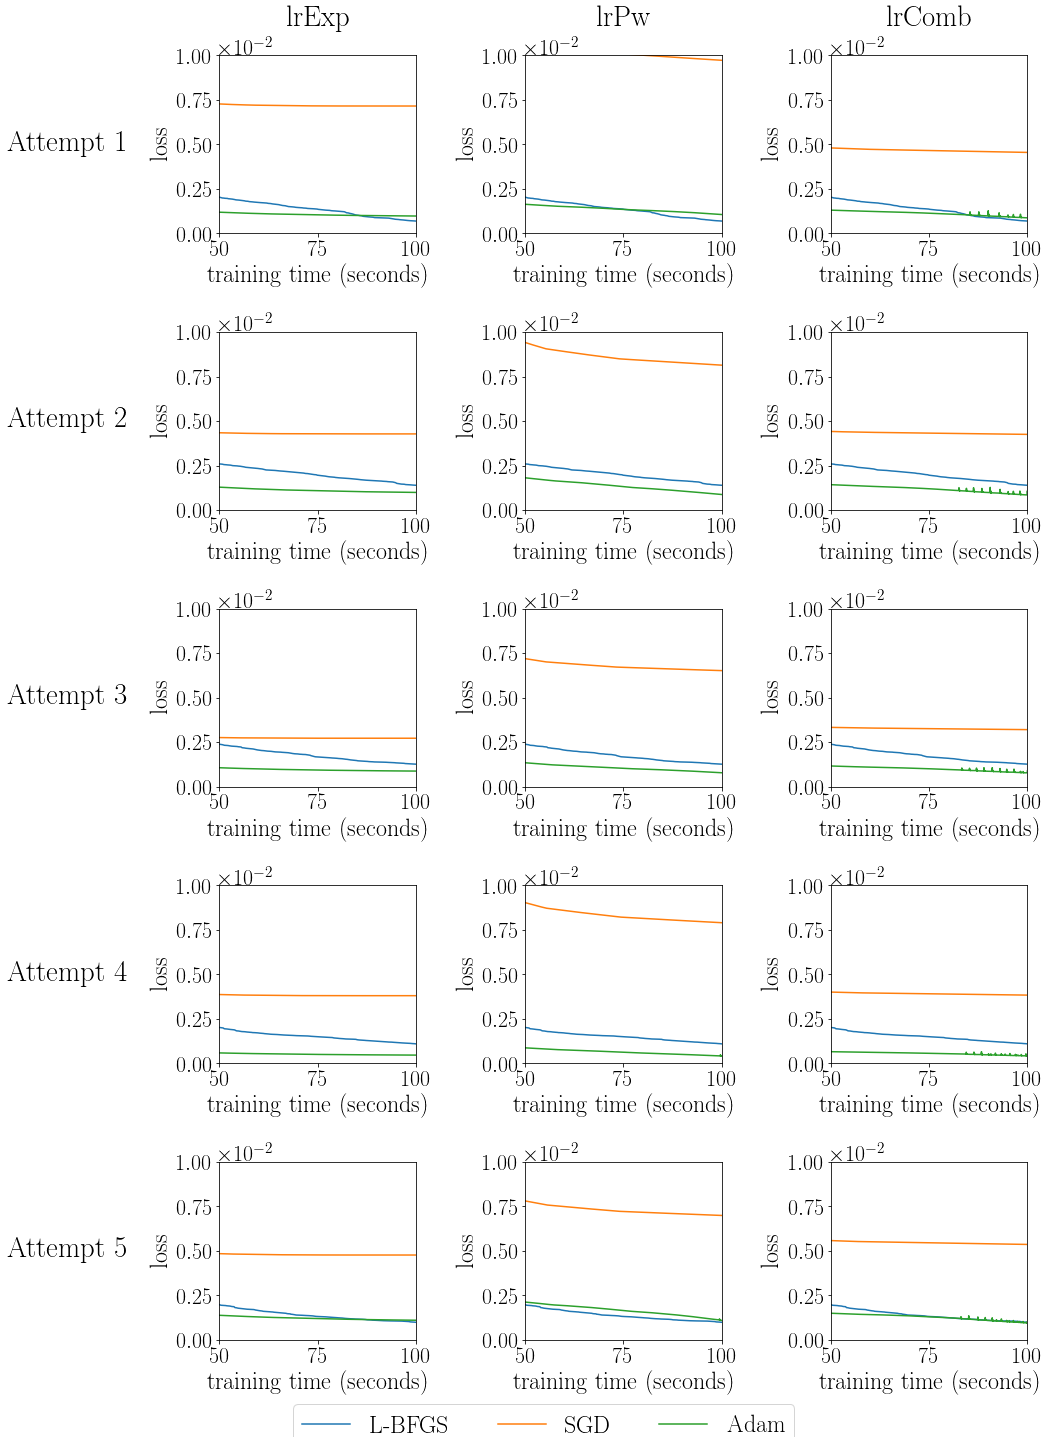

In [ ]:
fig, axes = plt.subplots(nrows=n_models, ncols=3, figsize=(15.1,20))

for i in range(n_models):
  axes[i,0].plot(np.linspace(0, timeout, len(hists_LBFGS[i])), hists_LBFGS[i])
  axes[i,0].plot(np.linspace(0, timeout, len(hists_SGD_exp[i])), hists_SGD_exp[i])
  axes[i,0].plot(np.linspace(0, timeout, len(hists_Adam_exp[i])), hists_Adam_exp[i])
  
  axes[i,1].plot(np.linspace(0, timeout, len(hists_LBFGS[i])), hists_LBFGS[i])
  axes[i,1].plot(np.linspace(0, timeout, len(hists_SGD_pw[i])), hists_SGD_pw[i])
  axes[i,1].plot(np.linspace(0, timeout, len(hists_Adam_pw[i])), hists_Adam_pw[i])

  axes[i,2].plot(np.linspace(0, timeout, len(hists_LBFGS[i])), hists_LBFGS[i])
  axes[i,2].plot(np.linspace(0, timeout, len(hists_SGD_comb[i])), hists_SGD_comb[i])
  axes[i,2].plot(np.linspace(0, timeout, len(hists_Adam_comb[i])), hists_Adam_comb[i])


cols = ['lrExp', 'lrPw', 'lrComb']
rows = ['Attempt {}'.format(row) for row in range(1, n_models+1)]

pad = 20 # in points

for ax_row in axes:
  for ax in ax_row:    
    ax.set_xlabel('training time (seconds)')
    ax.set_ylabel('loss')
    ax.set_xlim([50,100])
    ax.set_ylim([0,10e-3])
    ax.ticklabel_format(axis='y', scilimits=(0,0))

for ax, col in zip(axes[0], cols):
  ax.annotate(col, xy=(0.5, 1.05), xytext=(0, pad),
              xycoords='axes fraction', textcoords='offset points',
              size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
  ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
              xycoords=ax.yaxis.label, textcoords='offset points',
              size='large', ha='right', va='center')

# fig.suptitle('$Riwayat \it{Loss}$ pada Lima \nModel yang Dikembangkan', y=1.05, fontsize=25)

# fig.subplots_adjust(left=0.01, wspace=0.2, hspace=1)
fig.tight_layout()
fig.legend(['L-BFGS', 'SGD', 'Adam'], loc='lower center', bbox_to_anchor=(0.5, -0.015), ncol=3, frameon=True)

# plt.savefig('heat_eqn_fwd_hists.pdf', dpi=600, bbox_inches='tight', facecolor='none')

plt.show()

### Hasil Prediksi Model

In [8]:
Nt = 1000; Nx = 1000
tspace = np.linspace(lb[0], ub[0], Nt + 1)
xspace = np.linspace(lb[1], ub[1], Nx + 1)
T, X = np.meshgrid(tspace, xspace)

In [9]:
print("Koordinat x, 5 elemen pertama:", list(xspace[:5]))
print("Koordinat x, 5 elemen terakhir:", list(xspace[-5:]), "\n")

print("Koordinat t, 5 elemen pertama:", list(tspace[:5]))

print("Koordinat t, 5 elemen terakhir:", list(tspace[-5:]), "\n")

Koordinat x, 5 elemen pertama: [0.0, 0.006, 0.012, 0.018000000000000002, 0.024]
Koordinat x, 5 elemen terakhir: [5.976, 5.982, 5.988, 5.994, 6.0] 

Koordinat t, 5 elemen pertama: [0.0, 0.01, 0.02, 0.03, 0.04]
Koordinat t, 5 elemen terakhir: [9.96, 9.97, 9.98, 9.99, 10.0] 



#### Solusi Eksplisit dan Solusi Skema Crank Nicolson

Solusi analitik untuk persamaan panas.

In [10]:
path = dir + "/Data/"

# # Solusi Eksplisit
# u_star = np.empty([len(xspace), len(tspace)])
# i = 0
# for x_i in xspace:
#   j = 0
#   for t_i in tspace:
#     sum = 0
#     u_star[i][j] = u_expl(t_i, x_i); j += 1
#   i += 1

# np.savetxt(path + "u_star_heat.csv", u_star)

u_star = np.loadtxt(path + "u_star_heat.csv")

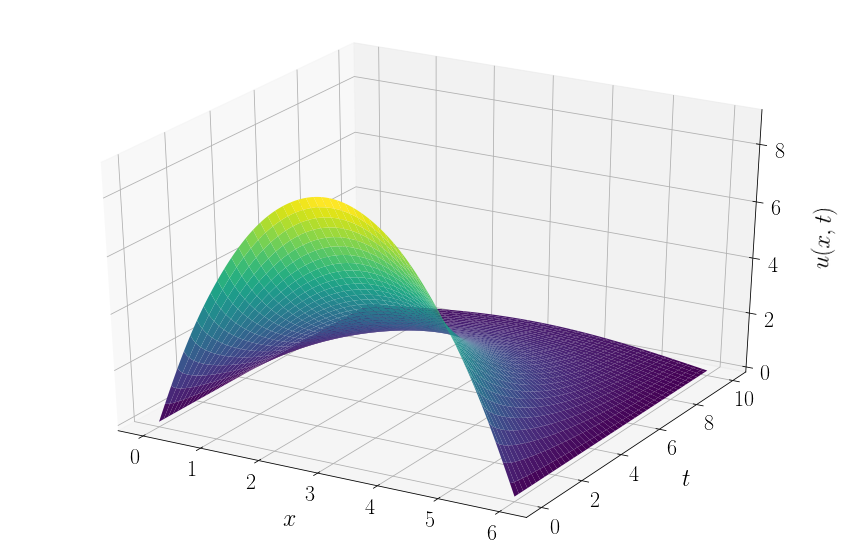

In [11]:
# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, u_star, cmap='viridis');
# ax.view_init(35,35)
ax.set_xlabel('$x$', labelpad=20)
ax.set_ylabel('$t$', labelpad=20)
ax.set_zlabel('$u(x,t)$', labelpad=20)
# ax.set_title('Solusi analitik untuk persamaan panas.');

# plt.savefig('heat_eqn_fwd_exact.pdf', bbox_inches='tight', dpi=600, facecolor='none')
plt.show()

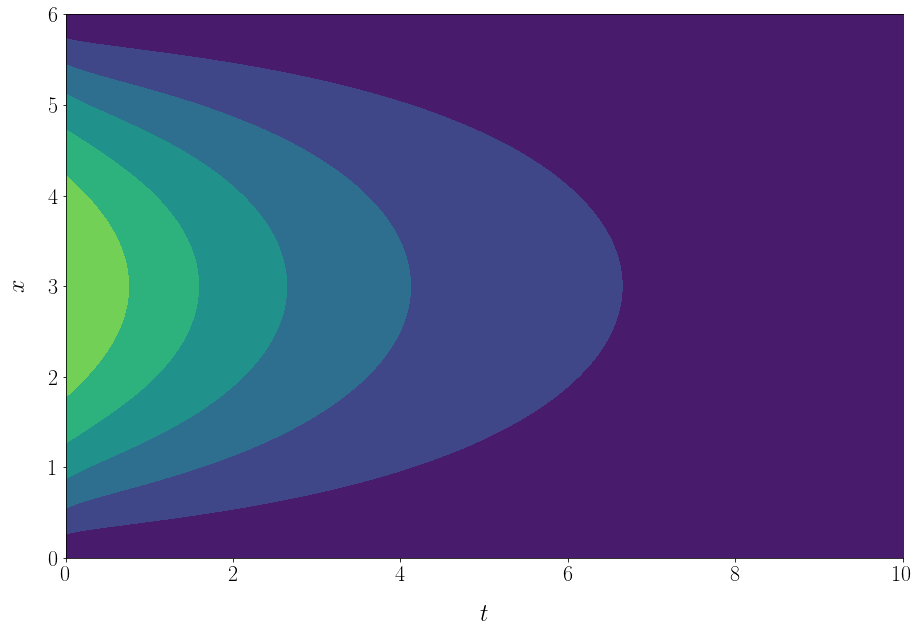

In [12]:
# Contour plot of solution u(t,x)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.contourf(T, X, u_star, cmap='viridis');
ax.set_xlabel('$t$', labelpad=20)
ax.set_ylabel('$x$', labelpad=20)
# ax.set_title('Solusi analitik untuk persamaan panas.');

# plt.savefig('heat_eqn_fwd_exact_contour.pdf', bbox_inches='tight', dpi=600, facecolor='none')
plt.show()

Solusi Skema Numerik Crank-Nicolson

In [13]:
path = dir + "/Data/"
u_CN = np.genfromtxt(path + "u_CN.csv", dtype=DTYPE, delimiter=',', skip_header = 0)
u_CN.shape

(1001, 1001)

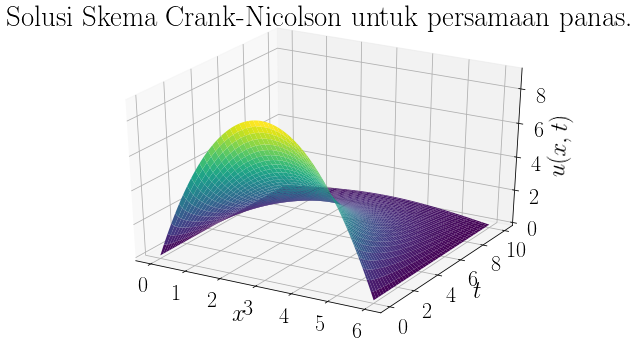

In [14]:
# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, u_CN, cmap='viridis');
# ax.view_init(35,35)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u(x,t)$')
ax.set_title('Solusi Skema Crank-Nicolson untuk persamaan panas.');

In [15]:
u_CN.shape

(1001, 1001)

#### Evaluasi Galat Model

Prediksi solusi dengan model-model yang telah dibuat.

In [16]:
preds_LBFGS = []
preds_SGD_exp = []
preds_SGD_pw = []
preds_SGD_comb = []
preds_Adam_exp = []
preds_Adam_pw = []
preds_Adam_comb = []

for i in range(n_models):
  preds_LBFGS.append(pinn.predict_solution(models_LBFGS[i], Nt, Nx))
  preds_SGD_exp.append(pinn.predict_solution(models_SGD_exp[i], Nt, Nx))
  preds_SGD_pw.append(pinn.predict_solution(models_SGD_pw[i], Nt, Nx))
  preds_SGD_comb.append(pinn.predict_solution(models_SGD_comb[i], Nt, Nx))
  preds_Adam_exp.append(pinn.predict_solution(models_Adam_exp[i], Nt, Nx))
  preds_Adam_pw.append(pinn.predict_solution(models_Adam_pw[i], Nt, Nx))
  preds_Adam_comb.append(pinn.predict_solution(models_Adam_comb[i], Nt, Nx))

In [17]:
pinn.evaluate_solution(u_CN, u_star)

0.009623597086440611

In [18]:
df = pd.DataFrame(columns = ['L-BFGS' , 
                             'SGD (exp)', 'SGD (pw)', 'SGD (comb)',  
                             'Adam (exp)', 'Adam (pw)', 'Adam (comb)'])

for i in range(n_models):
  df.loc['Attempt '+str(i+1)] = [pinn.evaluate_solution(preds_LBFGS[i], u_star),
                                 pinn.evaluate_solution(preds_SGD_exp[i], u_star),
                                 pinn.evaluate_solution(preds_SGD_pw[i], u_star),
                                 pinn.evaluate_solution(preds_SGD_comb[i], u_star),
                                 pinn.evaluate_solution(preds_Adam_exp[i], u_star),
                                 pinn.evaluate_solution(preds_Adam_pw[i], u_star),
                                 pinn.evaluate_solution(preds_Adam_comb[i], u_star)]

df

,L-BFGS,SGD (exp),SGD (pw),SGD (comb),Adam (exp),Adam (pw),Adam (comb)
Attempt 1,0.256816,1.112397,4.136761,1.592261,0.256165,0.301725,0.238104
Attempt 2,0.333330,0.844470,2.086247,0.861389,0.257496,0.239977,0.233801
Attempt 3,0.278421,0.483044,1.560718,0.436278,0.248822,0.242324,0.266627
Attempt 4,0.318908,0.975391,2.771539,0.806861,0.184654,0.215944,0.160298
Attempt 5,0.211738,0.695911,1.676751,0.860461,0.282752,0.352446,0.257082


In [19]:
df.idxmin(axis=1)

Attempt 1    Adam (comb)
Attempt 2    Adam (comb)
Attempt 3      Adam (pw)
Attempt 4    Adam (comb)
Attempt 5         L-BFGS
dtype: object

In [20]:
print(df.mean(axis=0))
df.loc['Average'] = df.mean(axis=0)

L-BFGS         0.279843
SGD (exp)      0.822242
SGD (pw)       2.446403
SGD (comb)     0.911450
Adam (exp)     0.245978
Adam (pw)      0.270483
Adam (comb)    0.231182
dtype: float64


In [21]:
print(tabulate(df.round(4), headers='keys', tablefmt='latex', floatfmt="#.4f"))

\begin{tabular}{lrrrrrrr}
\hline
           &   L-BFGS &   SGD (exp) &   SGD (pw) &   SGD (comb) &   Adam (exp) &   Adam (pw) &   Adam (comb) \\
\hline
 Attempt 1 &   0.2568 &      1.1124 &     4.1368 &       1.5923 &       0.2562 &      0.3017 &        0.2381 \\
 Attempt 2 &   0.3333 &      0.8445 &     2.0862 &       0.8614 &       0.2575 &      0.2400 &        0.2338 \\
 Attempt 3 &   0.2784 &      0.4830 &     1.5607 &       0.4363 &       0.2488 &      0.2423 &        0.2666 \\
 Attempt 4 &   0.3189 &      0.9754 &     2.7715 &       0.8069 &       0.1847 &      0.2159 &        0.1603 \\
 Attempt 5 &   0.2117 &      0.6959 &     1.6768 &       0.8605 &       0.2828 &      0.3524 &        0.2571 \\
 Average   &   0.2798 &      0.8222 &     2.4464 &       0.9114 &       0.2460 &      0.2705 &        0.2312 \\
\hline
\end{tabular}


#### Analisis Hasil Prediksi

In [22]:
u_PINN = preds_Adam_comb[3]

def tau(t):
  return int((Nt*(t - lb[0])/(ub[0] - lb[0])).numpy())

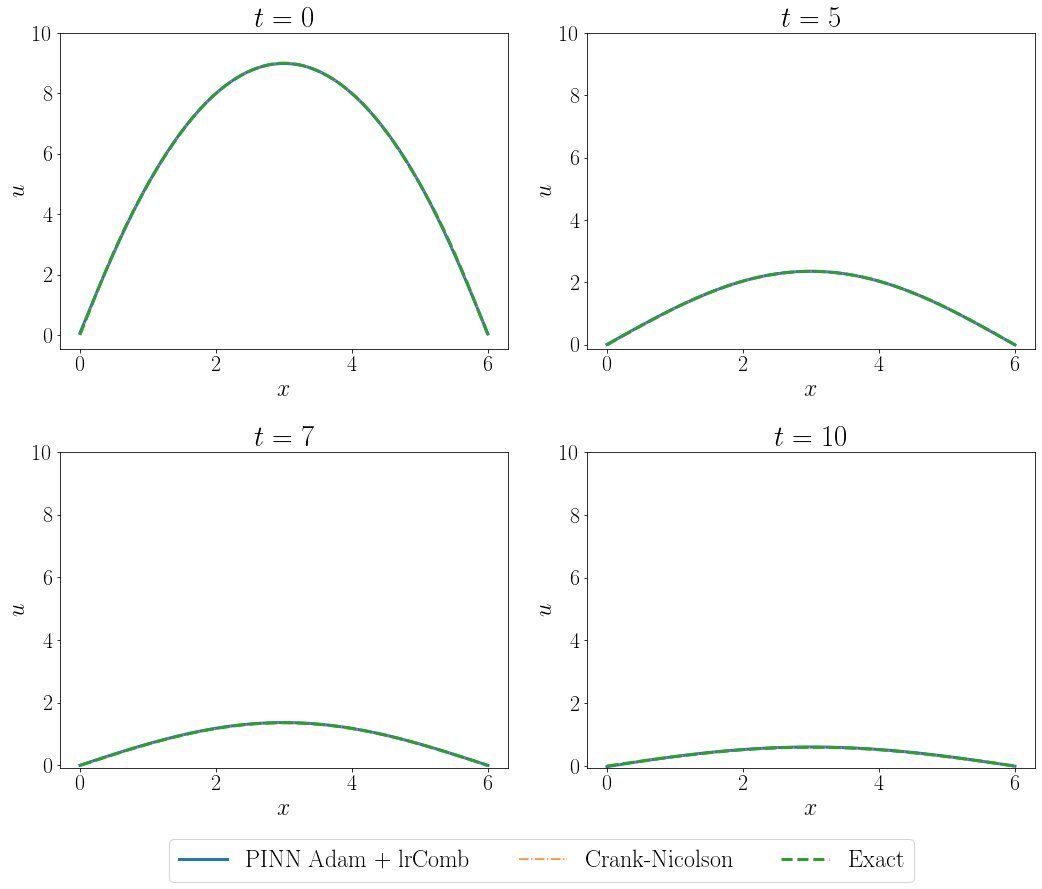

In [25]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

t1 = 0
ax1.plot(xspace,u_PINN[:,tau(t1)], lw=3)
ax1.plot(xspace,u_CN[:,tau(t1)], ls = "-.")
ax1.plot(xspace,u_star[:,tau(t1)], ls="--", lw=3)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$u$')
ax1.set_title('$t=0$')

t2 = 5
ax2.plot(xspace,u_PINN[:,tau(t2)], lw=3)
ax2.plot(xspace,u_CN[:,tau(t2)], ls = "-.")
ax2.plot(xspace,u_star[:,tau(t2)], ls="--", lw=3)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$u$')
ax2.set_title('$t=5$')

t3 = 7
ax3.plot(xspace,u_PINN[:,tau(t3)], lw=3)
ax3.plot(xspace,u_CN[:,tau(t3)], ls = "-.")
ax3.plot(xspace,u_star[:,tau(t3)], ls="--", lw=3)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$u$')
ax3.set_title('$t=7$')

t4 = 10
ax4.plot(xspace,u_PINN[:,tau(t4)], lw=3)
ax4.plot(xspace,u_CN[:,tau(t4)], ls = "-.")
ax4.plot(xspace,u_star[:,tau(t4)], ls="--", lw=3)
ax4.set_xlabel('$x$')
ax4.set_ylabel('$u$')
ax4.set_title('$t=10$')

ax1.set_yticks(np.arange(0, 8+3, 2))
ax2.set_yticks(np.arange(0, 8+3, 2))
ax3.set_yticks(np.arange(0, 8+3, 2))
ax4.set_yticks(np.arange(0, 8+3, 2))

plt.tight_layout()
plt.legend(['PINN Adam + lrComb', 'Crank-Nicolson', 'Exact'], 
           loc='lower center', bbox_to_anchor=(-0.1, -0.4), ncol=3, frameon=True)

# plt.savefig('heat_eqn_sol.pdf', dpi=600, bbox_inches='tight', facecolor='none')

plt.show()

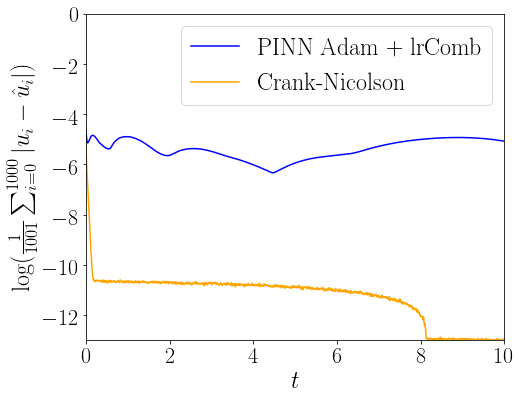

In [26]:
plt.figure(figsize=(7.5, 6))
plt.plot(tspace, pinn.evaluate_solution_log_time(u_PINN, u_star), c='blue')
plt.plot(tspace, pinn.evaluate_solution_log_time(u_CN, u_star), c='orange')
plt.xlabel('$t$')
plt.ylabel('$\log(\\frac{1}{1001}\sum_{i=0}^{1000}{|u_i-\hat{u}_i|})$')
plt.xlim([0,10])
plt.ylim([-13,0])

plt.legend(['PINN Adam + lrComb', 'Crank-Nicolson'])

# plt.savefig('heat_eqn_sol_error.pdf', dpi=600, bbox_inches='tight', facecolor='none')

plt.show()

#Masalah Invers

## 1. Persiapan Pemodelan

### Pembangkitan Data *Training* dan *Collocation Points* untuk Masalah Invers

In [ ]:
N_d = 500
noise = 0.0

plot = True

# Set random seed for reproducible results
tf.random.set_seed(0)

if plot == True:  
  # Draw points with measurements randomly
  t_d = tf.random.uniform((N_d,1), lb[0], ub[0], dtype=DTYPE)
  x_d = tf.random.uniform((N_d,1), lb[1], ub[1], dtype=DTYPE)
  X_d = tf.concat([t_d, x_d], axis=1)
  
  # Explicit analytical solution
  u_d = u_expl(t_d, x_d)
  u_d += noise * tf.random.normal(u_d.shape, dtype=DTYPE)

elif plot == False:
  X_d, u_d = pinn.generate_collocation_points(N_d, lb, ub, u_expl, noise=0)

X_param = [X_d]
u_param = [u_d]

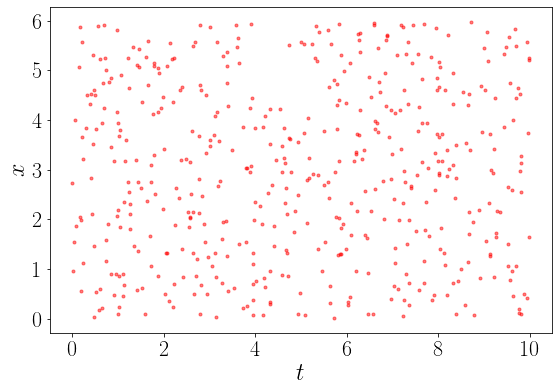

In [ ]:
fig = plt.figure(figsize=(9,6))
plt.scatter(t_d, x_d, c='r', marker='.', alpha=0.5)
plt.xlabel('$t$')
plt.ylabel('$x$')

# plt.title('(b) Visualisasi koordinat data $\it{training}$ dan $\it{collocation\;points}$ untuk masalah invers persamaan panas.');
# plt.savefig('heat_eqn_inv_train.pdf', bbox_inches='tight', dpi=600, facecolor='none')

plt.show()

### Persiapan Arsitektur PINN

Pada *hidden layer* pertama, terdapat $2 \times 20 = 40$ parameter bobot dan $20$ parameter bias. Pada *hidden layer* selanjutnya, terdapat $20 \times 20 = 400$ parameter bobot dan $20$ parameter bias dalam setiap *layer*. Di *output layer* yang terhubung *hidden layer* terakhir, terdapat $1 \times 20 = 20$ parameter bobot dan $20$ parameter bias. 

Maka, terdapat sejumlah
    \begin{align*}
        1 \times (40+20) + 1 \times (400+20) + 1 \times (20+20) = 520
    \end{align*}
    parameter yang dapat ditentukan dan diperbarui pada setiap *epoch* dalam PINN.

In [ ]:
arch = {'output_dim':1, 'num_hidden_layers':2, 'num_neurons_per_layer':20}
n_models = 5

In [ ]:
models = [None] * n_models

for i in range(n_models):
  tf.random.set_seed(i)
  models[i] = pinn.PINN_IdentificationNet(initial_lambda=0.0, lb=lb, ub=ub, **arch)
  models[i].build((None, 2))

### Persiapan Perhitungan *Loss Function*

In [ ]:
def get_r(t, x, model, fun_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        # t, x = X_r[:, 0:1], X_r[:,1:2]
        
        tape.watch(x)
        with tf.GradientTape(persistent=True) as tape2:
          # Variables t and x are watched during tape
          # to compute derivatives u_t and u_x
          tape2.watch(t)
          tape2.watch(x)

          # Determine residual 
          u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_t = tape2.gradient(u, t)
        u_x = tape2.gradient(u, x)
            
    
    u_xx = tape.gradient(u_x, x)

    del tape
    del tape2

    return fun_r(t, x, u, u_t, u_x, u_xx, model)
  
def fun_r(t, x, u, u_t, u_x, u_xx, model):
  return u_t + model.lambd * u_xx

In [ ]:
def get_r_param(t, x, model):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        # t, x = X_r[:, 0:1], X_r[:,1:2]
        
        tape.watch(x)
        with tf.GradientTape(persistent=True) as tape2:
          # Variables t and x are watched during tape
          # to compute derivatives u_t and u_x
          tape2.watch(t)
          tape2.watch(x)

          # Determine residual 
          u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_t = tape2.gradient(u, t)
        u_x = tape2.gradient(u, x)
            
    
    u_xx = tape.gradient(u_x, x)

    del tape
    del tape2

    with tf.GradientTape(persistent=True) as tape_lambd:
      tape_lambd.watch(model.lambd)
      r = u_t + model.lambd * u_xx
      loss = tf.reduce_mean(tf.square(r))
    
    g = tape_lambd.gradient(loss, model.lambd)
    
    del tape_lambd    

    return loss, g

## 2. Persiapan *Optimizer*

Karena data yang digunakan lebih sedikit untuk kasus masalah invers, maka iterasi *optimizer* berbasis *gradient descent* akan menjadi lebih banyak. Maka, boundary untuk *learning rate* yang akan digunakan pada *Piecewise Constant Decay* harus lebih besar.

In [ ]:
# lr_pw = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,7000],[1e-1,1e-2,1e-3])

# # Choose the optimizer
# optim_SGD = tf.keras.optimizers.SGD(learning_rate=lr_pw)
# optim_Adam = tf.keras.optimizers.Adam(learning_rate=lr_pw)

# boundaries = [3000,7000]
# values = [1e-1,1e-2,1e-3]
lr_comb_param = {'boundaries': [3000,7000,14000],
                 'initial_learning_rate': 1e-1,
                 'decay_steps': 150,
                 'decay_rate': 0.9,
                 'values_steps': 2}
lr_comb = CombinedDecay(**lr_comb_param)
lr_comb.get_config()

{'initial_learning_rate': 0.1,
 'decay_steps': 150,
 'decay_rate': 0.9,
 'staircase': False,
 'boundaries': [3000, 7000, 14000],
 'values': [0.012157665459056936,
  0.006078832729528468,
  0.003039416364764234,
  0.001519708182382117],
 'values_steps': [2, 2, 2],
 'name': None}

## 3. *Training* Model

In [ ]:
n_models = 5
timeout = 100
initial_lambdas = [0.0, -5.0, 10.0]
path = dir + "/model weights/heat_eqn_inv"

old_timeout = timeout
models_LBFGS = [None] * n_models
models_SGD = [None] * n_models
models_Adam = [None] * n_models
hists_LBFGS = [None] * n_models
hists_SGD = [None] * n_models
hists_Adam = [None] * n_models


for i in range(n_models):
  timeout = old_timeout
  models_LBFGS[i] = []
  models_SGD[i] = []
  models_Adam[i] = []
  hists_LBFGS[i] = []
  hists_SGD[i] = []
  hists_Adam[i] = []

  for j in range(len(initial_lambdas)):
    if initial_lambdas[j] >= 10:
      timeout *= 2

    print('{:s}\nIteration: {:d} Initial lambda: {}\n{:s}'.format(50*'-',i+1,initial_lambdas[j],50*'-'))
    # Prepare models' architecture
    models_LBFGS[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_SGD[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_Adam[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch)) 
    
    models_LBFGS[i][j].build((None, 2))
    models_SGD[i][j].build((None, 2))
    models_Adam[i][j].build((None, 2))

    # Copy weights from the previous model instance to make every iteration comparable
    models_LBFGS[i][j].set_weights(models[i].get_weights())
    models_SGD[i][j].set_weights(models[i].get_weights())
    models_Adam[i][j].set_weights(models[i].get_weights())
    
    # Assigning initial lambda
    models_LBFGS[i][j].trainable_variables[-1].assign(initial_lambdas[j])
    models_SGD[i][j].trainable_variables[-1].assign(initial_lambdas[j])
    models_Adam[i][j].trainable_variables[-1].assign(initial_lambdas[j])

    # Prepare optimizer
    optim_SGD = tf.keras.optimizers.SGD(learning_rate=lr_comb)
    optim_Adam = tf.keras.optimizers.Adam(learning_rate=lr_comb)

    # Initialize solver
    solver_LBFGS = pinn.PINN_IdentificationSolver(models_LBFGS[i][j], X_d, fun_r, get_r)
    solver_SGD = pinn.PINN_IdentificationSolver(models_SGD[i][j], X_d, fun_r, get_r)
    solver_Adam = pinn.PINN_IdentificationSolver(models_Adam[i][j], X_d, fun_r, get_r)

    # Train models
    print('\n\nL-BFGS\n')
    solver_LBFGS.solve_with_ScipyOptimizer(X_param, u_param,
                                          timeout=timeout,
                                          method='L-BFGS-B')
    print('\n\nSGD\n')
    solver_SGD.solve_with_TFoptimizer(optim_SGD, X_param, u_param, timeout=timeout)
    print('\n\nAdam\n')
    solver_Adam.solve_with_TFoptimizer(optim_Adam, X_param, u_param, timeout=timeout)
    
    # Store evolution of lambdas and hists
    hists_LBFGS[i].append(np.array([models_LBFGS[i][j].lambd_list, solver_LBFGS.hist]))
    hists_SGD[i].append(np.array([models_SGD[i][j].lambd_list, solver_SGD.hist]))
    hists_Adam[i].append(np.array([models_Adam[i][j].lambd_list, solver_Adam.hist]))

    print('\n\n\n')

Streaming output truncated to the last 5000 lines.
It 41450: loss = 1.18532407e+00 lambda = 101.60387
It 41500: loss = 1.18913984e+00 lambda = 101.607445
It 41550: loss = 1.18527305e+00 lambda = 101.611374
It 41600: loss = 1.18856061e+00 lambda = 101.61528
It 41650: loss = 1.18544948e+00 lambda = 101.61871
It 41700: loss = 1.18542922e+00 lambda = 101.62229
It 41750: loss = 1.18528104e+00 lambda = 101.62635
It 41800: loss = 1.18558359e+00 lambda = 101.629776
It 41850: loss = 1.18511534e+00 lambda = 101.63385
It 41900: loss = 1.18620944e+00 lambda = 101.637115
It 41950: loss = 1.18506813e+00 lambda = 101.64089
It 42000: loss = 1.18582571e+00 lambda = 101.64433
It 42050: loss = 1.18702888e+00 lambda = 101.648224
It 42100: loss = 1.18499660e+00 lambda = 101.65173
It 42150: loss = 1.18983150e+00 lambda = 101.655785
It 42200: loss = 1.18506742e+00 lambda = 101.65912
It 42250: loss = 1.19104707e+00 lambda = 101.66294
It 42300: loss = 1.18878734e+00 lambda = 101.666504
It 42350: loss = 1.18485

### *Export* Model

*Export* bobot dan bias yang diperoleh pada *training*.

In [ ]:
path = dir + "/model weights/heat_eqn_inv"

for i in range(n_models):
  for j in range(len(initial_lambdas)):
    models_LBFGS[i][j].save_weights(path+"_"+str(i)+"/model_LBFGS_"+str(j)+".h5", 'h5')
    models_SGD[i][j].save_weights(path+"_"+str(i)+"/model_SGD_"+str(j)+".h5", 'h5')
    models_Adam[i][j].save_weights(path+"_"+str(i)+"/model_Adam_"+str(j)+".h5", 'h5')

*Export* perkembangan *loss* pada *training* dalam bentuk `hist`.

In [ ]:
for i in range(n_models):
  for j in range(len(initial_lambdas)):
    np.savetxt(path+"_"+str(i)+"/loss and param/hist_LBFGS_"+str(j)+".txt", hists_LBFGS[i][j])
    np.savetxt(path+"_"+str(i)+"/loss and param/hist_SGD_"+str(j)+".txt", hists_SGD[i][j])
    np.savetxt(path+"_"+str(i)+"/loss and param/hist_Adam_"+str(j)+".txt", hists_Adam[i][j])

### *Import* Model

In [ ]:
n_models = 5
timeout = 100
initial_lambdas = [0.0, -5.0, 10.0]
path = dir + "/model weights/heat_eqn_inv"

models_LBFGS = [None] * n_models
models_SGD = [None] * n_models
models_Adam = [None] * n_models
hists_LBFGS = [None] * n_models
hists_SGD = [None] * n_models
hists_Adam = [None] * n_models

for i in range(n_models):
  models_LBFGS[i] = []
  models_SGD[i] = []
  models_Adam[i] = []
  hists_LBFGS[i] = []
  hists_SGD[i] = []
  hists_Adam[i] = []

  for j in range(len(initial_lambdas)):
    models_LBFGS[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_SGD[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch))
    models_Adam[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch)) 
    
    models_LBFGS[i][j].build((None, 2))
    models_SGD[i][j].build((None, 2))
    models_Adam[i][j].build((None, 2))

    models_LBFGS[i][j].load_weights(path+"_"+str(i)+"/model_LBFGS_"+str(j)+".h5", 'h5')
    models_SGD[i][j].load_weights(path+"_"+str(i)+"/model_SGD_"+str(j)+".h5", 'h5')
    models_Adam[i][j].load_weights(path+"_"+str(i)+"/model_Adam_"+str(j)+".h5", 'h5')

    hists_LBFGS[i].append(np.loadtxt(path+"_"+str(i)+"/loss and param/hist_LBFGS_"+str(j)+".txt"))
    hists_SGD[i].append(np.loadtxt(path+"_"+str(i)+"/loss and param/hist_SGD_"+str(j)+".txt"))
    hists_Adam[i].append(np.loadtxt(path+"_"+str(i)+"/loss and param/hist_Adam_"+str(j)+".txt"))

## Grafik

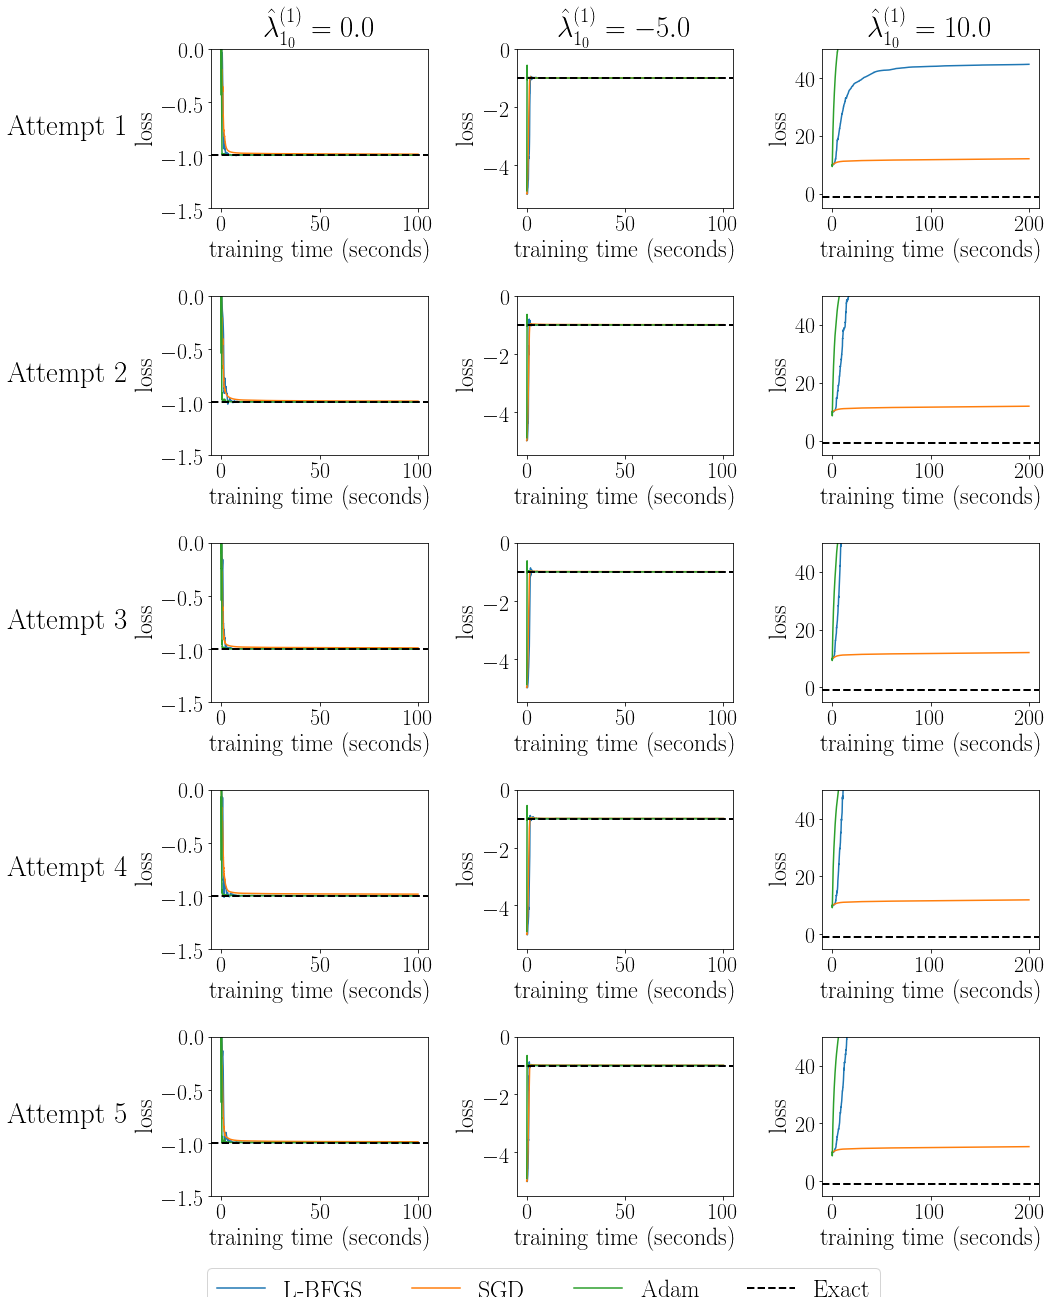

In [ ]:
fig, axes = plt.subplots(nrows=n_models, ncols=3, figsize=(15.1,18))

for i in range(n_models):
  timeout = 100
  axes[i,0].plot(np.linspace(0, timeout, len(hists_LBFGS[i][0][0])), hists_LBFGS[i][0][0])
  axes[i,0].plot(np.linspace(0, timeout, len(hists_SGD[i][0][0])), hists_SGD[i][0][0])
  axes[i,0].plot(np.linspace(0, timeout, len(hists_Adam[i][0][0])), hists_Adam[i][0][0])
  axes[i,0].set_ylim([-1.5,0])

  axes[i,1].plot(np.linspace(0, timeout, len(hists_LBFGS[i][1][0])), hists_LBFGS[i][1][0])
  axes[i,1].plot(np.linspace(0, timeout, len(hists_SGD[i][1][0])), hists_SGD[i][1][0])
  axes[i,1].plot(np.linspace(0, timeout, len(hists_Adam[i][1][0])), hists_Adam[i][1][0])
  axes[i,1].set_ylim([-5.5,0])

  timeout = 200
  axes[i,2].plot(np.linspace(0, timeout, len(hists_LBFGS[i][2][0])), hists_LBFGS[i][2][0])
  axes[i,2].plot(np.linspace(0, timeout, len(hists_SGD[i][2][0])), hists_SGD[i][2][0])
  axes[i,2].plot(np.linspace(0, timeout, len(hists_Adam[i][2][0])), hists_Adam[i][2][0])
  axes[i,2].set_ylim([-5,50])

timeout = 100
cols = ['$\hat{\lambda}_{1_0}^{(1)} = 0.0$', '$\hat{\lambda}_{1_0}^{(1)} = -5.0$', '$\hat{\lambda}_{1_0}^{(1)} = 10.0$']
rows = ['Attempt {}'.format(row) for row in range(1, n_models+1)]

pad = 5 # in points

for ax_row in axes:
  for ax in ax_row:    
    ax.set_xlabel('training time (seconds)')
    ax.set_ylabel('loss')
    ax.axhline(y=-1, c="black",linewidth=2,linestyle='--')

for ax, col in zip(axes[0], cols):
  ax.annotate(col, xy=(0.5, 1.05), xytext=(0, pad),
              xycoords='axes fraction', textcoords='offset points',
              size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
  ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
              xycoords=ax.yaxis.label, textcoords='offset points',
              size='large', ha='right', va='center')

# fig.suptitle('Riwayat Tebakan Parameter pada \nLima Model yang Dikembangkan', y=1.05, fontsize=25)

# fig.subplots_adjust(left=0.01, top=0.6)
fig.tight_layout()
fig.legend(['L-BFGS', 'SGD', 'Adam', 'Exact'], loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=4, frameon=True)

# plt.savefig('heat_eqn_inv_hists.pdf', dpi=600, bbox_inches='tight', facecolor='none')
# plt.savefig('heat_eqn_inv_hists.png', dpi=600, bbox_inches='tight', facecolor='none')

plt.show()

## Analisis Hasil Prediksi

In [ ]:
def lambdas(hists, iter_model, iter_init, N=500):
  return sum(hists[iter_model][iter_init][0][-N:].tolist()) / N

df = pd.DataFrame(columns = ['L-BFGS_0', 'SGD_0', 'Adam_0',
                             'L-BFGS_1', 'SGD_1', 'Adam_1',
                             'L-BFGS_2', 'SGD_2', 'Adam_2'])

for i in range(n_models):
  x = []
  for j in range(len(initial_lambdas)):
    x.append(lambdas(hists_LBFGS, i, j))
    x.append(lambdas(hists_SGD, i, j))
    x.append(lambdas(hists_Adam, i, j))
  
  df.loc['Attempt '+str(i+1)] = x

df

,L-BFGS_0,SGD_0,Adam_0,L-BFGS_1,SGD_1,Adam_1,L-BFGS_2,SGD_2,Adam_2
Attempt 1,-1.000210,-0.990310,-1.000511,-1.000000,-0.997376,-1.000474,44.676849,12.087043,89.086001
Attempt 2,-1.000429,-0.991413,-1.000211,-0.999626,-0.991037,-1.000266,79.844293,11.881104,103.669328
Attempt 3,-1.000011,-0.990272,-1.000848,-0.999842,-0.995016,-1.000303,102.440598,12.059423,86.209023
Attempt 4,-1.000079,-0.984722,-1.000166,-0.999021,-0.993205,-1.000267,86.617476,11.909382,102.407320
Attempt 5,-0.999991,-0.992110,-1.000564,-0.999826,-0.992454,-0.999988,90.394137,11.937849,99.391000


In [ ]:
print(df.mean(axis=0))
df.loc['Average'] = df.mean(axis=0)

L-BFGS_0    -1.000144
SGD_0       -0.989766
Adam_0      -1.000460
L-BFGS_1    -0.999663
SGD_1       -0.993818
Adam_1      -1.000260
L-BFGS_2    80.794671
SGD_2       11.974960
Adam_2      96.152534
dtype: float64


In [ ]:
print(tabulate(df.round(4), headers='keys', tablefmt='latex', floatfmt="#.4f"))

\begin{tabular}{lrrrrrrrrr}
\hline
           &   L-BFGS\_0 &   SGD\_0 &   Adam\_0 &   L-BFGS\_1 &   SGD\_1 &   Adam\_1 &   L-BFGS\_2 &   SGD\_2 &   Adam\_2 \\
\hline
 Attempt 1 &    -1.0002 & -0.9903 &  -1.0005 &    -1.0000 & -0.9974 &  -1.0005 &    44.6768 & 12.0870 &  89.0860 \\
 Attempt 2 &    -1.0004 & -0.9914 &  -1.0002 &    -0.9996 & -0.9910 &  -1.0003 &    79.8443 & 11.8811 & 103.6693 \\
 Attempt 3 &    -1.0000 & -0.9903 &  -1.0008 &    -0.9998 & -0.9950 &  -1.0003 &   102.4406 & 12.0594 &  86.2090 \\
 Attempt 4 &    -1.0001 & -0.9847 &  -1.0002 &    -0.9990 & -0.9932 &  -1.0003 &    86.6175 & 11.9094 & 102.4073 \\
 Attempt 5 &    -1.0000 & -0.9921 &  -1.0006 &    -0.9998 & -0.9925 &  -1.0000 &    90.3941 & 11.9378 &  99.3910 \\
 Average   &    -1.0001 & -0.9898 &  -1.0005 &    -0.9997 & -0.9938 &  -1.0003 &    80.7947 & 11.9750 &  96.1525 \\
\hline
\end{tabular}


## *Training* Model *Hybrid*

In [ ]:
n_models = 5
timeout = 100
initial_lambdas = [0.0, -5.0, 10.0]
path = dir + "/model weights/heat_eqn_inv"

models = [None] * n_models
models_Adam = [None] * n_models
hists_Adam = [None] * n_models


for i in range(n_models):
  tf.random.set_seed(i)
  models[i] = pinn.Hybrid_IdentificationNet(initial_lambda=0.0, lb=lb, ub=ub, **arch)
  models[i].build((None, 2))

  models_Adam[i] = []
  hists_Adam[i] = []

  for j in range(len(initial_lambdas)):
    print('{:s}\nIteration: {:d} Initial lambda: {}\n{:s}'.format(50*'-',i+1,initial_lambdas[j],50*'-'))
    models_Adam[i].append(pinn.Hybrid_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch)) 
    models_Adam[i][j].build((None, 2))

    # Copy weights from the previous model instance to make every iteration comparable
    models_Adam[i][j].set_weights(models[i].get_weights())
    
    # Assigning initial lambda
    models_Adam[i][j].initial_lambda = initial_lambdas[j]

    # Prepare optimizer for learning given data
    optim_Adam = tf.keras.optimizers.Adam(learning_rate=lr_comb)    

    # Prepare optimizer for minimizing PDE function and finding PDE parameters
    optim_inv_Adam = tf.keras.optimizers.Adam(learning_rate=lr_comb)

    # Initialize solver
    solver_hybrid = pinn.Hybrid_IdentificationSolver(models_Adam[i][j], X_d, fun_r, get_r)

    # Train models
    print('\n\nAdam\n')
    solver_hybrid.solve(optim_Adam, optim_inv_Adam, get_r_param, X_param, u_param, 
                        timeout_param=timeout*0.2, timeout=timeout*0.8)
    
    # Store evolution of lambdas and hists
    hists_Adam[i].append(np.array([models_Adam[i][j].lambd_list, solver_hybrid.hist]))

    print('\n\n\n')

--------------------------------------------------
Iteration: 1 Initial lambda: 0.0
--------------------------------------------------


Adam

Initial Learning Rate = 1.00000e-01
It 00000: l_u = 7.70811367e+00 loss = 7.70811367e+00
It 00050: l_u = 4.86300625e-02 loss = 4.86300625e-02
It 00100: l_u = 4.38092789e-03 loss = 4.38092789e-03
It 00150: l_u = 2.33833794e-03 loss = 2.33833794e-03
It 00200: l_u = 1.51923893e-03 loss = 1.51923893e-03
It 00250: l_u = 1.20170321e-02 loss = 1.20170321e-02
It 00300: l_u = 1.52171985e-03 loss = 1.52171985e-03
It 00350: l_u = 9.55815252e-04 loss = 9.55815252e-04
It 00400: l_u = 7.23004632e-04 loss = 7.23004632e-04
It 00450: l_u = 5.84482623e-04 loss = 5.84482623e-04
It 00500: l_u = 4.92322957e-04 loss = 4.92322957e-04
It 00550: l_u = 4.25209902e-04 loss = 4.25209902e-04
It 00600: l_u = 3.73436254e-04 loss = 3.73436254e-04
It 00650: l_u = 3.39327613e-03 loss = 3.39327613e-03
It 00700: l_u = 4.90973529e-04 loss = 4.90973529e-04
It 00750: l_u = 4.00761637

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Streaming output truncated to the last 5000 lines.
It 04550: l_u = 4.70591185e-05 loss = 4.70591185e-05
It 04600: l_u = 4.64866462e-05 loss = 4.64866462e-05
It 04650: l_u = 4.59135808e-05 loss = 4.59135808e-05
It 04700: l_u = 1.37591167e-04 loss = 1.37591167e-04
It 04750: l_u = 4.61879135e-05 loss = 4.61879135e-05
It 04800: l_u = 4.46941267e-05 loss = 4.46941267e-05
It 04850: l_u = 4.41536868e-05 loss = 4.41536868e-05
It 04900: l_u = 4.36226219e-05 loss = 4.36226219e-05
It 04950: l_u = 4.30942491e-05 loss = 4.30942491e-05
It 05000: l_u = 4.26773877e-05 loss = 4.26773877e-05
It 05050: l_u = 7.75328590e-05 loss = 7.75328590e-05
It 05100: l_u = 4.19595344e-05 loss = 4.19595344e-05
It 05150: l_u = 4.13900088e-05 loss = 4.13900088e-05
It 05200: l_u = 4.08905908e-05 loss = 4.08905908e-05
It 05250: l_u = 4.03979866e-05 loss = 4.03979866e-05
It 05300: l_u = 1.33241861e-04 loss = 1.33241861e-04
It 05350: l_u = 4.02706646e-05 loss = 4.02706646e-05
It 05400: l_u = 3.94841591e-05 loss = 3.94841591

In [ ]:
def lambdas(hists, iter_model, iter_init, N=500):
  return sum(hists[iter_model][iter_init][0][-N:]) / N

df = pd.DataFrame(columns = ['Adam_0','Adam_1','Adam_2'])

for i in range(n_models):
  x = []
  for j in range(len(initial_lambdas)):
    x.append(lambdas(hists_Adam, i, j))
  
  df.loc['Attempt '+str(i+1)] = x

df

,Adam_0,Adam_1,Adam_2
Attempt 1,-0.906663,-0.908812,-0.909444
Attempt 2,-0.930717,-0.926635,-0.931234
Attempt 3,-0.914794,-0.920105,-0.921664
Attempt 4,-0.949585,-0.947415,-0.949183
Attempt 5,-0.800823,-0.800850,-0.799337


In [ ]:
print(df.mean(axis=0))
df.loc['Average'] = df.mean(axis=0)

Adam_0   -0.900516
Adam_1   -0.900763
Adam_2   -0.902172
dtype: float64


In [ ]:
print(tabulate(df.round(4), headers='keys', tablefmt='latex', floatfmt="#.4f"))

\begin{tabular}{lrrr}
\hline
           &   Adam\_0 &   Adam\_1 &   Adam\_2 \\
\hline
 Attempt 1 &  -0.9067 &  -0.9088 &  -0.9094 \\
 Attempt 2 &  -0.9307 &  -0.9266 &  -0.9312 \\
 Attempt 3 &  -0.9148 &  -0.9201 &  -0.9217 \\
 Attempt 4 &  -0.9496 &  -0.9474 &  -0.9492 \\
 Attempt 5 &  -0.8008 &  -0.8008 &  -0.7993 \\
 Average   &  -0.9005 &  -0.9008 &  -0.9022 \\
\hline
\end{tabular}


### Export Model

In [ ]:
path = dir + "/model weights/heat_eqn_inv_hybrid"

for i in range(n_models):
  for j in range(len(initial_lambdas)):
    models_Adam[i][j].save_weights(path+"/model_Adam_hy_"+str(i)+"_"+str(j)+".h5", 'h5')

for i in range(n_models):
  for j in range(len(initial_lambdas)):
    np.savetxt(path+"/loss and param/hist_Adam_hy_"+str(i)+"_"+str(j)+".txt", hists_Adam[i][j][0])

### *Import* Model

In [ ]:
n_models = 5
timeout = 100
initial_lambdas = [0.0, -5.0, 10.0]
path = dir + "/model weights/heat_eqn_inv_hybrid"

models_Adam = [None] * n_models
hists_LBFGS = [None] * n_models
hists_SGD = [None] * n_models
hists_Adam = [None] * n_models

for i in range(n_models):
  models_Adam[i] = []
  hists_Adam[i] = []

  for j in range(len(initial_lambdas)):
    models_Adam[i].append(pinn.PINN_IdentificationNet(initial_lambda=initial_lambdas[j], lb=lb, ub=ub, **arch)) 
    models_Adam[i][j].build((None, 2))
    models_Adam[i][j].load_weights(path+"/model_Adam_hy_"+str(i)+"_"+str(j)+".h5", 'h5')

    hists_Adam[i].append(np.loadtxt(path+"/loss and param/hist_Adam_hy_"+str(i)+"_"+str(j)+".txt"))

## *Unused*

In [ ]:
# Initilize PINN solver
solver_LBFGS = pinn.PINN_PDESolver(model_LBFGS, X_r, fun_r, get_r)

solver_SGD_exp = pinn.PINN_PDESolver(model_SGD_exp, X_r, fun_r, get_r)
solver_SGD_pw = pinn.PINN_PDESolver(model_SGD_pw, X_r, fun_r, get_r)
solver_SGD_comb = pinn.PINN_PDESolver(model_SGD_comb, X_r, fun_r, get_r)

solver_Adam_exp = pinn.PINN_PDESolver(model_Adam_exp, X_r, fun_r, get_r)
solver_Adam_pw = pinn.PINN_PDESolver(model_Adam_pw, X_r, fun_r, get_r)
solver_Adam_comb = pinn.PINN_PDESolver(model_Adam_comb, X_r, fun_r, get_r)

In [ ]:
# Unable to save whole model due to the keras model class being customised
# model_LBFGS.save("model_LBFGS")
# model_SGD_exp.save("model_SGD_exp")
# model_SGD_pw.save("model_SGD_pw")
# model_SGD_comb.save("model_SGD_comb")
# model_Adam_exp.save("model_Adam_exp")
# model_Adam_pw.save("model_Adam_pw")
# model_Adam_comb.save("model_Adam_comb")

model_LBFGS.save_weights("model_LBFGS.h5", 'h5')
model_SGD_exp.save_weights("model_SGD_exp.h5", 'h5')
model_SGD_pw.save_weights("model_SGD_pw.h5", 'h5')
model_SGD_comb.save_weights("model_SGD_comb.h5", 'h5')
model_Adam_exp.save_weights("model_Adam_exp.h5", 'h5')
model_Adam_pw.save_weights("model_Adam_pw.h5", 'h5')
model_Adam_comb.save_weights("model_Adam_comb.h5", 'h5')


from google.colab import files
files.download("model_LBFGS.h5");
files.download("model_SGD_exp.h5");
files.download("model_SGD_pw.h5");
files.download("model_SGD_comb.h5");
files.download("model_Adam_exp.h5");
files.download("model_Adam_pw.h5");
files.download("model_Adam_comb.h5");

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### *Import* Model

In [ ]:
path = dir + "/model weights/heat_eqn_fwd/"
model_LBFGS.load_weights(path+"model_LBFGS.h5")
model_SGD_exp.load_weights(path+"model_SGD_exp.h5")
model_SGD_pw.load_weights(path+"model_SGD_pw.h5")
model_SGD_comb.load_weights(path+"model_SGD_comb.h5")
model_Adam_exp.load_weights(path+"model_Adam_exp.h5")
model_Adam_pw.load_weights(path+"model_Adam_pw.h5")
model_Adam_comb.load_weights(path+"model_Adam_comb.h5")